# ENVIRONMENT

In [87]:
from statistics import harmonic_mean, mean, stdev

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     cross_val_score, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import predictive_lib as lib

# auto reload modules
%load_ext autoreload
%autoreload 2

# suppress scientific notation in Pandas
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("precision", 3)
pd.set_option("display.max_colwidth", None)

plt.rcParams["figure.figsize"] = [12, 10]
plt.rcParams["figure.dpi"] = 150

sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

import warnings

warnings.filterwarnings("ignore")

RANDOM_STATE = 1

UNPROCESSED_TARGET_VAR = "Bandwidth_GB_Year"
TARGET_VAR = "Bandwidth_GB_Year"

rnd = lambda x: round(x, 2)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
original_df = pd.read_csv("./src/ChurnData/churn_clean.csv")

# Part 0: Data Exploration
---

In [ ]:
explore_df = original_df.copy()


In [ ]:
explore_df.shape


In [ ]:
explore_df.info()


In [ ]:
explore_df.describe()


In [ ]:
explore_df.head()


In [ ]:
display(pd.DataFrame(explore_df.isnull().sum(), columns=["# Missing Values"]))


In [ ]:
explore_df = explore_df.drop(
    [
        "CaseOrder",
        "Customer_id",
        "Interaction",
        "UID",
        "City",
        "State",
        "County",
        "Zip",
        "TimeZone",
        "Job",
        "Lat",
        "Lng",
    ],
    axis=1,
    errors="ignore",
)

for col in explore_df.select_dtypes("object").columns:
    print(f"Converting feature: '{col}' to category datatype")
    explore_df[col] = explore_df[col].astype("category")

explore_df.info()


In [ ]:
pd.DataFrame(
    {
        "# missing values": explore_df.isna().sum(),
        "% missing values": (explore_df.isna().sum() / len(explore_df)) * 100,
    }
)


In [ ]:
cats_df = explore_df.copy().select_dtypes("category")

nunique_df = pd.DataFrame(
    {"Unique Values": cats_df.nunique(), "K-1 Levels": cats_df.nunique() - 1}
)

nunique_df


In [ ]:
ctg_columns = explore_df.select_dtypes("category").columns

# drop a level for features with < 2 levels
category_df = pd.get_dummies(
    explore_df, columns=ctg_columns, dummy_na=False, drop_first=True, prefix_sep="_"
)

category_df.head()


In [ ]:
_ = category_df.hist(figsize=(30, 30))
plt.subplots_adjust(hspace=0.5, wspace=0.5)


In [ ]:
fig, axs = plt.subplots(figsize=(20, 5))

age_bins = pd.cut(explore_df.Age.round(0), precision=0, bins=[18, *range(30, 91, 10)])

_ = sns.countplot(x=age_bins, palette="Set2").set_title("10-Year Age Range Counts")


In [ ]:
_, ax = plt.subplots(figsize=(20, 5))

sns.countplot(data=explore_df, x=UNPROCESSED_TARGET_VAR)
plt.show()


In [ ]:
age_bins = pd.cut(explore_df.Age.round(0), precision=0, bins=[18, *range(30, 91, 10)])

plt.figure(figsize=(20, 5))

_ = sns.countplot(
    x=age_bins, hue=UNPROCESSED_TARGET_VAR, palette="Set2", data=explore_df
).set_title("Customer Churn in 10-Year Age Range Counts")


In [ ]:
ctg_cols = explore_df.select_dtypes("category").columns
fig, axs = plt.subplots(nrows=len(ctg_cols), figsize=(10, 60))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(ctg_cols):
    p = sns.countplot(data=explore_df, x=col, ax=axs[i])
    p.set_xlabel(p.get_xlabel(), size=8)
    p.set_ylabel(p.get_ylabel(), size=8)
    p.set_yticklabels(p.get_yticks(), size=8)
    p.set_xticklabels(p.get_xticklabels(), size=8)


In [ ]:
fig, axs = plt.subplots(figsize=(20, 5))

_ = sns.stripplot(y="Churn", x="Income", data=explore_df, jitter=0.35)


In [ ]:
_ = sns.catplot(x="Churn", y="Population", col="Area", data=explore_df, jitter=0.25)


In [ ]:
_ = sns.catplot(x="Churn", y="Population", col="Gender", data=explore_df, jitter=0.25)


In [ ]:
_ = sns.catplot(
    x="InternetService", y="Tenure", col="Churn", data=explore_df, jitter=0.25
)


In [ ]:
_ = sns.catplot(
    x="Gender",
    y="Population",
    hue="Churn",
    col="Area",
    data=explore_df.sample(n=2000),
    jitter=0.25,
)


In [ ]:
_ = sns.catplot(
    x="Area",
    y="Tenure",
    col="Churn",
    kind="box",
    data=explore_df,
    height=9,
)


In [ ]:
_ = sns.catplot(
    x="Gender",
    y="MonthlyCharge",
    col="Churn",
    kind="box",
    data=explore_df,
    height=9,
)


In [ ]:
_ = sns.catplot(
    x="Gender",
    y="Bandwidth_GB_Year",
    col="Churn",
    kind="box",
    data=explore_df,
    height=9,
)


In [ ]:
_ = sns.catplot(
    y="Yearly_equip_failure",
    col="Churn",
    kind="box",
    data=explore_df,
    height=9,
)


In [ ]:
_ = sns.catplot(
    x="Marital",
    y="Contacts",
    col="Churn",
    kind="box",
    data=explore_df,
    height=9,
)


In [ ]:
_ = sns.catplot(
    x="Area",
    y="Income",
    col="Churn",
    kind="box",
    data=explore_df.sample(n=1000),
    height=9,
)


In [ ]:
_ = sns.catplot(
    x="Gender",
    y="Children",
    col="Churn",
    kind="box",
    data=explore_df.sample(n=1000),
    height=9,
)


In [ ]:
lib.create_heatmap(explore_df, fontsize=18)


# Part I: Research Question 
---

## A.  Describe the purpose of this data mining report by doing the following:



### ✅ 1.  Propose one question relevant to a real-world organizational situation that you will answer using one of the following prediction methods: decision trees, random forests, advanced regression (i.e., lasso or ridge regression)
*The submission proposes 1 question that is relevant to a real-world organizational situation, and the proposal includes 1 of the given prediction methods.*


- Contacts: Number of times customer contacted technical support 
- Bandwidth_GB_Year: The average amount of data used, in GB, in a year by the customer
- Outage_sec_perweek: Average number of seconds per week of system outage's in the customer’s neighborhood
- Yearly_equip_failure: The number of times customer’s equipment failed and had to be reset/replaced in the past year (or if new customer, similar failures as seen in the new

> Based on the Telecommunications Churn dataset, can we mine the dataset to accurately predict the number of times a customer will contact technical support? We'll test this by creating, evaluating, and refining a ElasticNet regression prediction model. 

> Based on the Telecommunications Churn dataset, can we mine the dataset to accurately predict the average GB of data the customer number will use based on the services and add ons the customer selects? We'll test this by creating, evaluating, and refining a ElasticNet regression prediction model. 

> Based on the Telecommunications Churn dataset, can we mine the dataset to accurately predict the weekly system outage time in a customer's neighborhood? We'll test this by creating, evaluating, and refining a ElasticNet regression prediction model. 

> Based on the Telecommunications Churn dataset, can we mine the dataset to accurately predict the number of times a customer’s equipment will fail or need to be reset/replaced in a year? We'll test this by creating, evaluating, and refining a ElasticNet regression prediction model. 

---

> Based on the Telecommunications Churn dataset, can we mine the dataset to accurately classify if a customer will churn? We'll test this by creating, evaluating, and refining a ElasticNet regression prediction model. 

### ✅ 2. Define one goal of the data analysis. Ensure that your goal is reasonable within the scope of the scenario and is represented in the available data.
*The submission defines 1 reasonable goal for data analysis that is within the scope of the scenario and is represented in the available data.*

> There are several key objectives for this data analysis. The primary objective is to create a model that models a linear relationship between a customer's average annual data usage (dependent variable) and multiple independent variables related to the customer's selected services and add-ons. This model will determine what — if any — relationship exists between the customer's elections and their data usage. Furthermore, we'll determine if several explanatory variables can approximate a customer's data usage.

> Ultimately the goal is to better understand and predict our new and existing customer's expected data usage so we can provide them with the most appropriate pricing tier and support for their needs. Lastly, if this model proves accurate, it will provide data to inform customers as to what factors — if any — play a role in predicting their data usage.

---

> Since the telecommunications industry remains highly competitive and experiences high annual turnover rates, the goal is to use the KNN classification model to predict which customers are at high risk of churn. Additionally, this will spotlight which characteristics play a significant factor in customer churn. Once those customers and factors are identified, stakeholders can devise strategies to improve customer retention. This will ultimately allow the company to retain highly profitable and loyal customers.


# Part II: Method Justification

---

## B. Explain the reasons for your chosen prediction method from part A1 by doing the following:



### ✅ 1.  Explain how the classification method you chose analyzes the selected data set. Include expected outcomes.
*The submission logically explains how the chosen prediction method analyzes the selected data set and includes accurate expected outcomes.*

https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/
- "Fundamentally, classification is about predicting a label and regression is about predicting a quantity."
- "That regression is the problem of predicting a continuous quantity output for an example."
- "Predictive modeling is the problem of developing a model using historical data to make a prediction on new data where we do not have the answer."
- "Predictive modeling can be described as the mathematical problem of approximating a mapping function (f) from input variables (X) to output variables (y). This is called the problem of function approximation."
- "Regression predictive modeling is the task of approximating a mapping function (f) from input variables (X) to a continuous output variable (y)."
- "The job of the modeling algorithm is to find the best mapping function we can given the time and resources available."
- "A continuous output variable is a real-value, such as an integer or floating point value. These are often quantities, such as amounts and sizes."
- "A regression problem requires the prediction of a quantity."
- "A regression can have real valued or discrete input variables."
- "A problem with multiple input variables is often called a multivariate regression problem."
- "Some algorithms can be used for both classification and regression with small modifications, such as decision trees "


RIDGE REGRESSION https://machinelearningmastery.com/ridge-regression-with-python/
- "A problem with linear regression is that estimated coefficients of the model can become large, making the model sensitive to inputs and possibly unstable. This is particularly true for problems with few observations (samples) or less samples (n) than input predictors (p) or variables (so-called p >> n problems). One approach to address the stability of regression models is to change the loss function to include additional costs for a model that has large coefficients. Linear regression models that use these modified loss functions during training are referred to collectively as penalized linear regression. One popular penalty is to penalize a model based on the sum of the squared coefficient values (beta). This is called an L2 penalty. An L2 penalty minimizes the size of all coefficients, although it prevents any coefficients from being removed from the model by allowing their value to become zero."
---

>The classification technique uses one or more explanatory variables to determine which class a target variable belongs to. The KNN classification method will analyze the customer churn data set by utilizing labeled customer "input data to learn a function that produces appropriate output when given new unlabeled data" (Harrison, 2019). 

>More specifically, a KNN classifies a datapoint using "a plurality vote of its neighbors," meaning the classifier will assign the data point to the class most seen among its neighboring k data points. In this instance, k represents a non-negative integer that signifies how many neighboring data points to include during the vote (Wikipedia, 2022). In summary, this classification method assumes data points belonging to a similar class exist in proximity (Harrison, 2019).

>The KNN classifier is a supervised learning model, so to classify customer churn, the classifier will look at individual data features of a given customer and compare those data features to k other neighboring data points. Then the classifier will inspect whether those neighboring customer data points have churned — the most prominent outcome: churn or not churn will determine if the given data point likely belongs to a customer that will churn or has churned.

> The primary expected outcome from the KNN classifier is a discrete value that represents membership within a class (Harrison, 2019). The classifier will make predictions about customer churn and will be correct sometimes and incorrect other times. These classifier outcomes are best evaluated, understood, and compared using a Confusion Matrix and Receiver Operating Characteristic (ROC) Graph.

LASSO REGRESSION https://machinelearningmastery.com/lasso-regression-with-python/
- "Lasso Regression is a popular type of regularized linear regression that includes an L1 penalty. This has the effect of shrinking the coefficients for those input variables that do not contribute much to the prediction task. This penalty allows some coefficient values to go to the value of zero, allowing input variables to be effectively removed from the model, providing a type of automatic feature selection."
- "Lasso Regression is an extension of linear regression that adds a regularization penalty to the loss function during training."
- "A problem with linear regression is that estimated coefficients of the model can become large, making the model sensitive to inputs and possibly unstable. This is particularly true for problems with few observations (samples) or less samples (n) than input predictors (p) or variables (so-called p >> n problems). One approach to address the stability of regression models is to change the loss function to include additional costs for a model that has large coefficients. Linear regression models that use these modified loss functions during training are referred to collectively as penalized linear regression. A popular penalty is to penalize a model based on the sum of the absolute coefficient values. This is called the L1 penalty. An L1 penalty minimizes the size of all coefficients and allows some coefficients to be minimized to the value zero, which removes the predictor from the model."
- "An L1 penalty minimizes the size of all coefficients and allows any coefficient to go to the value of zero, effectively removing input features from the model. This acts as a type of automatic feature selection."
- "… a consequence of penalizing the absolute values is that some parameters are actually set to 0 for some value of lambda. Thus the lasso yields models that simultaneously use regularization to improve the model and to conduct feature selection." — Page 125, Applied Predictive Modeling, 2013.

https://en.wikipedia.org/wiki/Lasso_(statistics)
- "In statistics and machine learning, lasso (least absolute shrinkage and selection operator; also Lasso or LASSO) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the resulting statistical model."
- "It also reveals that (like standard linear regression) the coefficient estimates do not need to be unique if covariates are collinear."
- "Lasso was introduced in order to improve the prediction accuracy and interpretability of regression models. It selects a reduced set of the known covariates for use in a model."
- "Prior to lasso, the most widely used method for choosing covariates was stepwise selection. That approach only improves prediction accuracy in certain cases, such as when only a few covariates have a strong relationship with the outcome. However, in other cases, it can increase prediction error."
- "At the time, ridge regression was the most popular technique for improving prediction accuracy. Ridge regression improves prediction error by shrinking the sum of the squares of the regression coefficients to be less than a fixed value in order to reduce overfitting, but it does not perform covariate selection and therefore does not help to make the model more interpretable."
- "Lasso achieves both of these goals by forcing the sum of the absolute value of the regression coefficients to be less than a fixed value, which forces certain coefficients to zero, excluding them from impacting prediction. This idea is similar to ridge regression, which also shrinks the size of the coefficients, however Ridge Regression tends to set far fewer coefficients to zero."


RIDGE VS LASSO: https://www.quora.com/When-is-Ridge-regression-favorable-over-Lasso-regression
- "When you fit a linear model to your data, you are trying to minimize the mean squared error (MSE) between the model and the data. The data is usually split into two parts (train and test data). You fit the model to your training data, and then evaluate the model on unseen samples, known as your test set. A way of measuring how good a model fits with the data is by calculating the MSE. The smaller the MSE, the better the model. One issue that occurs is that your model may fit very well to your training set (MSE is small), but when you try it on the test set it does not work well (MSE is high). This is known as overfitting.

A way of controlling overfitting is by adding an extra term to the MSE that penalizes large coefficients in the model, known as regularization. There are two approaches to do this. One penalizes the sum of the squared coefficients, known as Ridge regularization. The other penalizes the sum of the absolute value of the coefficients, knows and Lasso regularization. As a result, a regularized linear regression with fine tunes parameters will not overfit, meaning that the MSE of both the train and test set will be similar."


ELASTIC NET: https://en.wikipedia.org/wiki/Elastic_net_regularization
- "In statistics and, in particular, in the fitting of linear or logistic regression models, the elastic net is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods."
- "The elastic net method overcomes the limitations of the LASSO (least absolute shrinkage and selection operator) method which uses a penalty function"
- "Use of this penalty function has several limitations.[1] For example, in the "large p, small n" case (high-dimensional data with few examples), the LASSO selects at most n variables before it saturates. Also if there is a group of highly correlated variables, then the LASSO tends to select one variable from a group and ignore the others. To overcome these limitations, the elastic net adds a quadratic part ({\displaystyle \|\beta \|^{2}}\|\beta\|^2) to the penalty, which when used alone is ridge regression (known also as Tikhonov regularization)."

ELASTIC NET: https://machinelearningmastery.com/elastic-net-regression-in-python/
- "An extension to linear regression involves adding penalties to the loss function during training that encourage simpler models that have smaller coefficient values. These extensions are referred to as regularized linear regression or penalized linear regression."
- "Elastic net is a popular type of regularized linear regression that combines two popular penalties, specifically the L1 and L2 penalty functions."
- "The coefficients of the model are found via an optimization process that seeks to minimize the sum squared error between the predictions (yhat) and the expected target values (y)."
- "A problem with linear regression is that estimated coefficients of the model can become large, making the model sensitive to inputs and possibly unstable. This is particularly true for problems with few observations (samples) or more samples (n) than input predictors (p) or variables (so-called p >> n problems)."
A problem with linear regression is that estimated coefficients of the model can become large, making the model sensitive to inputs and possibly unstable. This is particularly true for problems with few observations (samples) or more samples (n) than input predictors (p) or variables (so-called p >> n problems).

One approach to addressing the stability of regression models is to change the loss function to include additional costs for a model that has large coefficients. Linear regression models that use these modified loss functions during training are referred to collectively as penalized linear regression.

One popular penalty is to penalize a model based on the sum of the squared coefficient values. This is called an L2 penalty. An L2 penalty minimizes the size of all coefficients, although it prevents any coefficients from being removed from the model.

Another popular penalty is to penalize a model based on the sum of the absolute coefficient values. This is called the L1 penalty. An L1 penalty minimizes the size of all coefficients and allows some coefficients to be minimized to the value zero, which removes the predictor from the model.

Elastic net is a penalized linear regression model that includes both the L1 and L2 penalties during training.

Using the terminology from “The Elements of Statistical Learning,” a hyperparameter “alpha” is provided to assign how much weight is given to each of the L1 and L2 penalties. Alpha is a value between 0 and 1 and is used to weight the contribution of the L1 penalty and one minus the alpha value is used to weight the L2 penalty.

elastic_net_penalty = (alpha * l1_penalty) + ((1 – alpha) * l2_penalty)

For example, an alpha of 0.5 would provide a 50 percent contribution of each penalty to the loss function. An alpha value of 0 gives all weight to the L2 penalty and a value of 1 gives all weight to the L1 penalty.

The parameter alpha determines the mix of the penalties, and is often pre-chosen on qualitative grounds. — Page 663, The Elements of Statistical Learning, 2016.

The benefit is that elastic net allows a balance of both penalties, which can result in better performance than a model with either one or the other penalty on some problems.

Another hyperparameter is provided called “lambda” that controls the weighting of the sum of both penalties to the loss function. A default value of 1.0 is used to use the fully weighted penalty; a value of 0 excludes the penalty. Very small values of lambda, such as 1e-3 or smaller, are common.

elastic_net_loss = loss + (lambda * elastic_net_penalty)
Now that we are familiar with elastic net penalized regression, let’s look at a worked example.

- "That regression is the problem of predicting a continuous quantity output for an example."
- "Predictive modeling can be described as the mathematical problem of approximating a mapping function (f) from input variables (X) to output variables (y). This is called the problem of function approximation."
- "Regression predictive modeling is the task of approximating a mapping function (f) from input variables (X) to a continuous output variable (y)."
- "A continuous output variable is a real-value, such as an integer or floating point value. These are often quantities, such as amounts and sizes."
- "A regression problem requires the prediction of a quantity."

Elastic Net
- "Elastic net is a penalized linear regression model that includes both the L1 and L2 penalties during training."
    - "In statistics and, in particular, in the fitting of linear or logistic regression models, the elastic net is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods."
    - "overcomes the limitations of the LASSO"
- "An extension to linear regression involves adding penalties to the loss function during training that encourage simpler models that have smaller coefficient values."
- "A problem with linear regression is that estimated coefficients of the model can become large, making the model sensitive to inputs and possibly unstable."
- "One popular penalty is to penalize a model based on the sum of the squared coefficient values. This is called an L2 penalty. An L2 penalty minimizes the size of all coefficients, although it prevents any coefficients from being removed from the model. Another popular penalty is to penalize a model based on the sum of the absolute coefficient values. This is called the L1 penalty. An L1 penalty minimizes the size of all coefficients and allows some coefficients to be minimized to the value zero, which removes the predictor from the model."
- "The parameter alpha determines the mix of the penalties"
- "(alpha * l1_penalty) + ((1 – alpha) * l2_penalty)"
- "The benefit is that elastic net allows a balance of both penalties, which can result in better performance than a model with either one or the other penalty on some problems."

### ✅ 2.   Summarize one assumption of the chosen prediction method.
*The submission adequately summarizes 1 assumption of the chosen prediction method.*

https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/
- "Because a regression predictive model predicts a quantity, the skill of the model must be reported as an error in those predictions."
- "There are many ways to estimate the skill of a regression predictive model, but perhaps the most common is to calculate the root mean squared error, abbreviated by the acronym RMSE"
- "A benefit of RMSE is that the units of the error score are in the same units as the predicted value."
---

> There are several assumptions about a multiple regression model. First, we expect a linear relationship between the target and explanatory variables where the model's explanatory power increases with the number of explanatory variables. Secondly, data observations are selected independently and randomly from the population using statistically valid methods (Bevans, 2020). Additionally, the explanatory variables are not highly correlated, meaning there is no relationship or collinearity among independent variables (Bevans, 2020). Next, we expect that the data follow a normal distribution. We expect the model to produce a straight regression line through the data points with residuals normally distributed with a mean of 0. Lastly, we anticipate consistent homoscedasticity throughout the independent variables.


> There are several assumptions about the KNN classification method worth discussing. We'll focus on two assumptions: dimensionality and feature scaling.

> KNN models are susceptible to overfitting when there are too many data features to train against. Essentially, too many features create overly specific classification decision boundaries, require longer processing times and result in harder to interpret models. To alleviate these issues, we'll select the smallest subset of features that provide the most accurate model (Joby, 2021).

>Feature variance is another factor worth addressing. KNN classifiers make decisions based on the distance between data points. Consequently, a model may mistakenly hyperfocus on certain variables with a larger value range. To remedy this, we'll want to standardize numerical data features, before training a model. This will ensure our model does not rely on a data feature's measurement scale or allow larger values to dominate the algorithm (Bowne-Anderson, 2016).

### ✅ 3.  List the packages or libraries you have chosen for Python or R, and justify how each item on the list supports the analysis.
*The submission lists the packages or libraries chosen for Python or R and justifies how each item on the list supports the analysis.*

We'll use several tools and technologies to support the logistic regression analysis. The primary tools we'll discuss are Jupyter Notebooks, NumPy, Matplotlib, Pandas, Python, Statistics, Seaborn, and Scikit-Learn. 

Jupyter Notebooks is beneficial because it offers seamless integration of python, data visualizations, and text documentation. Ultimately this offers human-readable and executable documents used to perform data analysis (Ingargiola, A., & contributors, 2015).

NumPy is beneficial because it serves as the de-facto Python Numerical programming package. NumPy is easy to use, offers extensive computing tools, and is optimized to work well on large data sets.

Matplotlib is a comprehensive library for creating visualizations in Python. Matplotlib offers a diverse set of visualization offers, but we're mainly going to leverage its plotting functionality to better understand our data set and evaluate the model.

Pandas' manipulation and analysis functions are immensely beneficial. More specifically, it provides a user-friendly API for interacting with, manipulating, and performing operations on various data structures and tabular data (Pandas, 2022).

I'm familiar with Python and currently use it every day at work. I’m familiar with the programming ecosystem, its libraries, and its tools.

Scikit-learn is a machine learning library that provides tools for model fitting, data preprocessing, feature selection, model selection, model pipelines model evaluation, and many other utilities (scikit-learn developers, 2021). We'll use this package's modules to create a KNN model pipeline, impute data, standardize data, select independent variables as well as evaluate and tune the model.

Like Matplotlib, Seaborn is beneficial because it's based on matplotlib and offers features to make data visualizations more attractive.

# Part III: Data Preparation


---

## C.  Perform data preparation for the chosen data set by doing the following:

### 1.  Describe one data preprocessing goal relevant to the classification method from part A1.
*The submission describes 1 data preprocessing goal that is relevant to the classification method from part A1.*


In [ ]:
original_df = pd.read_csv("./src/ChurnData/churn_clean.csv")


#### Data Preprocessing Goals
> Creating a prediction model requires several data preparation steps and manipulations. First, we'll remove unneeded data features such as customer metadata, IDs, as well as career and geographic information. Additionally, we'll rename survey features and provide them with more descriptive labels. Furthermore, we'll format and sort feature names alphabetically to ensure label formats are consistent and easy to read. Next, we'll check for missing values and remove the records or impute the values using a mean value — we'll perform this action within a Sklearn Pipeline. Then, we'll convert nominal data features into categorical values and one-hot encode binary features with indicator variables. Likewise, we want to standardize our variables since models typically perform better when the data uses the same value scale. This step will provide us with independent variables with a mean of 0 and a standard deviation of 1 (AskPython, 2020). We'll perform this action within a Sklearn Pipeline. Lastly, we'll split our data into training, and test data sets so we can validate our model against unseen data.

---
> Creating a classification model requires several data preparation steps and manipulations. First, we'll remove unneeded data features such as customer metadata, IDs, as well as career and geographic information. Additionally, we'll rename survey features and provide them with more descriptive labels. Furthermore, we'll format and sort feature names alphabetically to ensure label formats are consistent and easy to read. Next, we'll check for missing values and remove the records or impute the values using a mean value — we'll perform this action within a Sklearn Pipeline. Then, we'll convert nominal data features into categorical values and one-hot encode binary features with indicator variables. Likewise, we want to standardize our variables since models typically perform better when the data uses the same value scale. This step will provide us with independent variables with a mean of 0 and a standard deviation of 1 (AskPython, 2020). We'll perform this action within a Sklearn Pipeline. Lastly, we'll split our data into training, and test data sets so we can validate our model against unseen data.


### 2.  Identify the initial data set variables that you will use to perform the analysis for the classification question from part A1, and classify each variable as continuous or categorical.
*The submission identifies the data set variables used to perform the analysis for the prediction question from part A1, and the submission accurately classifies each variable as continuous or categorical.*


In [ ]:
DROP_COLUMNS = [
    "CaseOrder",
    "Customer_id",
    "Interaction",
    "UID",
    "City",
    "State",
    "County",
    "Zip",
    "TimeZone",
    "Job",
    "Lat",
    "Lng",
]

for c in sorted(original_df.drop(DROP_COLUMNS, axis=1)):
    v_type = (
        "continuous" if original_df[c].dtype in ["int64", "float64"] else "categorical"
    )
    print(f'"{c}" is a {v_type} variable.')


### 3.  Explain each of the steps used to prepare the data for the analysis. Identify the code segment for each step.
*The submission accurately explains each step used to prepare the data for analysis, and the submission identifies an accurate code segment for each step.*


##### Drop Irrelevant Columns
> Use pandas.drop() to remove data features that won't be used in the model.

In [ ]:
DROP_COLUMNS = [
    "CaseOrder",
    "Customer_id",
    "Interaction",
    "UID",
    "City",
    "State",
    "County",
    "Zip",
    "TimeZone",
    "Job",
    "Lat",
    "Lng",
]

prep_df = original_df.drop(DROP_COLUMNS, axis=1)

prep_df.head()


##### Convert Object to Categorical Datatype
> By default, pandas will interpret nominal string values as "Object" data. We'll convert these data features to categories.

In [ ]:
for col in prep_df.select_dtypes("object").columns:
    print(f"Converting feature: '{col}' to category datatype")
    prep_df[col] = prep_df[col].astype("category")


In [ ]:
cats_df = prep_df.select_dtypes("category")

nunique_df = pd.DataFrame(
    {"Unique Values": cats_df.nunique(), "K-1 Levels": cats_df.nunique() - 1}
)

for num_unique in cats_df.nunique():
    assert num_unique > 1

nunique_df


##### Convert categorical variables into dummy/indicator variables
> One-hot encode categorical data features into multiple columns. To do this we'll find the number of unique values for the data feature and transform those values into K-1 columns using pandas.get_dummies()

In [ ]:
ctg_columns = list(prep_df.select_dtypes("category").columns)

# data features with more than 2 levels
k2_plus_features = prep_df[ctg_columns].nunique() > 2
k2_plus_cols = k2_plus_features[k2_plus_features == True].index

for col in k2_plus_cols:
    ctg_columns.remove(col)

# drop a level for features with < 2 levels
df = pd.get_dummies(
    prep_df, columns=ctg_columns, dummy_na=False, drop_first=True, prefix_sep="_"
)

# retain all levels for features with > 2 levels
df = pd.get_dummies(
    df, columns=k2_plus_cols, dummy_na=False, drop_first=False, prefix_sep="_"
)

TARGET_VAR = "Bandwidth_GB_Year"

df.head()


##### Format Feature Names and Sort Features Alphabetically
> Using pandas.DataFrame.rename, rename survey features and provide them with more descriptive labels. Additionally, format and sort feature names alphabetically to ensure consistently formatted labels.

In [ ]:
df.rename(
    columns={
        "Item1": "TimelyResponse",
        "Item2": "TimelyFixes",
        "Item3": "TimelyReplacements",
        "Item4": "Reliability",
        "Item5": "Options",
        "Item6": "RespectfulResponse",
        "Item7": "CourteousExchange",
        "Item8": "EvidenceOfActiveListening",
    },
    inplace=True,
)

df.head()


In [ ]:
# remove whitespace in new indicator features
# don't title case Bandwidth_GB_Year to Bandwidth_Gb_Year since GB and Gb are different units
df.columns = [c.title() if "_" in c and "GB" not in c else c for c in df.columns]
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("-", "_")

df = df[sorted(df.columns)]
df.head(1).T

##### Separate Dependent and Independent Variables
> Define "X" as the prepared data frame with the target variable removed. Define "y" as the prepared data frame with the explanatory variables removed.

In [ ]:
X = df.drop(TARGET_VAR, axis=1)
y = df[[TARGET_VAR]]


##### Impute Missing Values
*NOTE: actual transformation happens in Model Pipeline*
> Using sklearn.impute.SimpleImputer, find missing values and impute their values using the mean value.

In [ ]:
missing_df = pd.DataFrame(
    Pipeline(
        steps=[("imp", SimpleImputer(missing_values=np.nan, strategy="mean"))]
    ).fit_transform(X, y),
    columns=X.columns,
)

missing_df.head()


In [ ]:
pd.DataFrame(
    {
        "# missing values": missing_df.isna().sum(),
        "% missing values": (missing_df.isna().sum() / len(missing_df)) * 100,
    }
)


##### Standardize Numeric Variables 
*NOTE: actual transformation happens in Model Pipeline*
> Use sklearn.preprocessing.StandardScaler to scale the explanatory variables, yielding variables with a mean of 0 and a standard deviation of 1.

In [ ]:
std_df = pd.DataFrame(
    Pipeline(steps=[("scaler", StandardScaler())]).fit_transform(X, y),
    columns=X.columns,
)
std_df.head()


In [ ]:
_ = std_df.hist(figsize=(20, 25), grid=False)
plt.subplots_adjust(hspace=0.5, wspace=0.5)


##### Splitting Data (Train/Test)
> Using the defined explanatory and target variables, split the prepared data set. Reserve 20% of the dataset for testing and the remaining 80% for training the model. Both datasets will consist of an equal proportion of customers who've churned.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

display(X_train.head())

display(y_train.head())


In [ ]:
df.describe()


### 4.  Provide a copy of the cleaned data set.
*The submission includes an accurate copy of the cleaned data set.*

In [ ]:
df.to_csv("./churn_data_prepared.csv", index=False)


# Part IV: Analysis


---

## D.  Perform the data analysis and report on the results by doing the following:



### 1.  Split the data into training and test data sets and provide the file(s).
*The submission provides reasonably proportioned training and test data sets.*

In [5]:
# reset the dataframe to the cleaned CSV to eliminating needing to prepare the data again
df = pd.read_csv("./churn_data_prepared.csv")

TARGET_VAR = "Bandwidth_GB_Year"

X = df.drop(TARGET_VAR, axis=1)
y = df[[TARGET_VAR]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# merge split data sets using their index and write to a file
pd.merge(X_train, y_train, left_index=True, right_index=True).to_csv(
    "./churn_data_train.csv", index=False
)
pd.merge(X_test, y_test, left_index=True, right_index=True).to_csv(
    "./churn_data_test.csv", index=False
)


### 2.  Describe the analysis technique you used to appropriately analyze the data. Include screenshots of the intermediate calculations you performed.
*The submission accurately describes the analysis technique used to appropriately analyze the data, and the submission includes accurate screenshots of the intermediate calculations performed.*


> After we've prepared the data and created training and test sets, we'll create a sklearn.pipeline.Pipeline with default sklearn.neighbors.KNeighborsClassifier that we'll keep as a baseline model to compare against. The data analysis process will be iterative as we add pipeline steps, tune parameters and evaluate the cause and effect of our decisions. Each successive model will build and improve upon the baseline model. Our second model will feature an imputation step to impute missing data using the mean values. The third model will standardize the explanatory values. The fourth model will explore feature selection using LinearSVC.

> We'll objectively evaluate each model using GridSearchCV to cross-validate the results. Additionally, GridSearchCV will speed up hyperparameter tuning by allowing us to understand the optimal hyperparameter ranges to focus on. During this initial tuning, we'll test broad ranges for several hyperparameters to determine what effect — if any — the parameter value has on the test accuracy. We'll continue this until we've identified parameters and parameter options that are worth further tuning. Lastly, for each classifier, we'll explore the training and test accuracy, the classification metrics, the ROC Graph, feature correlation, and the selected features. We'll use these model evaluation metrics to determine how to refine our model and select data features.

> Finally, once we have a pipeline model that's properly tuned, we'll create a final model that does not include the feature selection step. After that, we'll perform a final validation to ensure all the selected features are beneficial and are not highly correlated with other selected features.

### 3.  Provide the code used to perform the classification analysis from part D2.
*The submission provides the code used to perform the classification analysis from part D2 and the code executes without errors.*


In [ ]:
# reset the dataframe to the cleaned CSV to eliminating needing to prepare the data again
df = pd.read_csv("./churn_data_prepared.csv")

TARGET_VAR = "Bandwidth_GB_Year"

X = df.drop(TARGET_VAR, axis=1)
y = df[[TARGET_VAR]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# merge split data sets using their index and write to a file
pd.merge(X_train, y_train, left_index=True, right_index=True).to_csv(
    "./churn_data_train.csv", index=False
)
pd.merge(X_test, y_test, left_index=True, right_index=True).to_csv(
    "./churn_data_test.csv", index=False
)


#### LASSO Regression

##### Baseline LASSO Regression
```
Train MAE: 0.42
Test MAE: 10.95
```

,# Variables,Train MAE,Test MAE,Best Model Params
0,52,0.42,10.95,"{'lasso__alpha': 1, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__positive': False, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': False}"


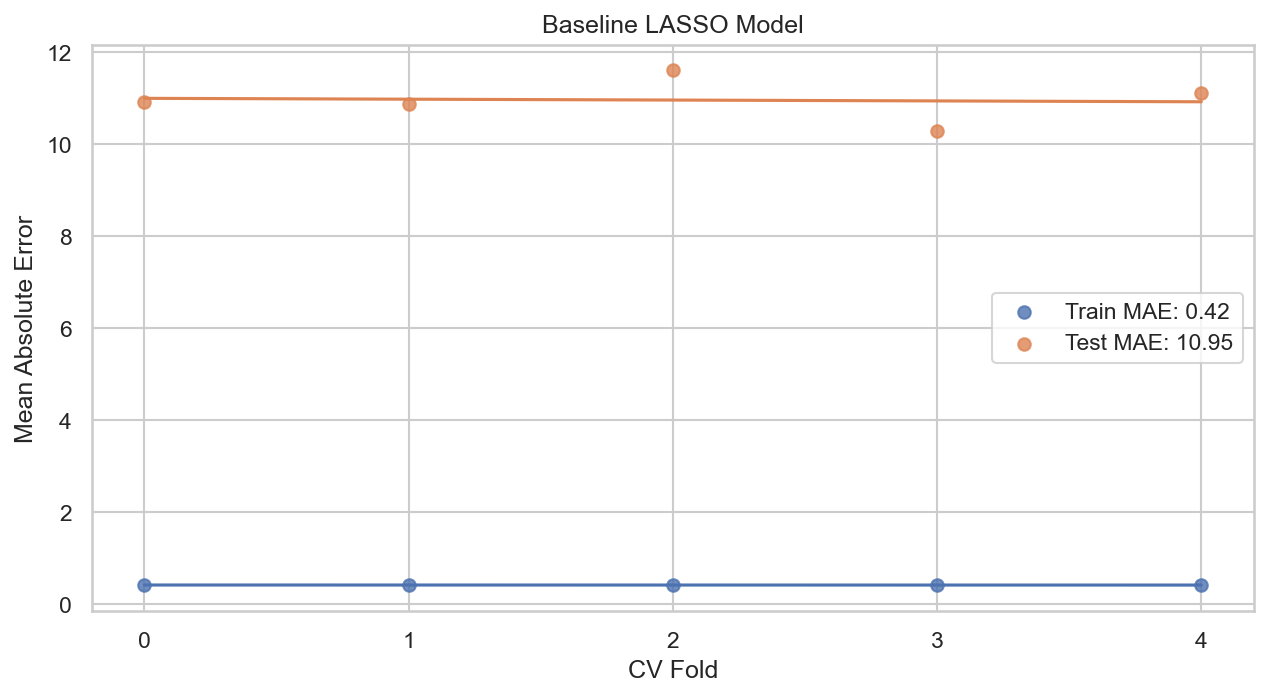

In [30]:
from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [("scaler", StandardScaler()), ("lasso", Lasso(random_state=RANDOM_STATE))]
steps = [("lasso", Lasso(random_state=RANDOM_STATE))]

param_grid = {
    "lasso__alpha": [1],
    "lasso__fit_intercept": [True],
    "lasso__max_iter": [1000],
    "lasso__tol": [1e-4],
    "lasso__warm_start": [False],    
    "lasso__positive": [False],
    "lasso__selection": ["cyclic"],    
}

pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

y_pred = cv.predict(X_test)

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline LASSO Model", xticks=[]
)

##### LASSO Feature Importance

Best alpha using built-in LassoCV: 2.1632598661033566
Best score using built-in LassoCV: -2408.9228507132557
selected cols Index(['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male',
       'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes',
       'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes',
       'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure'],
      dtype='object')
Lasso selected 15 variables and eliminated 37 variables


,Feature,Feature Importance,Feature Importance (SN)
0,Age,-65.77,-6.576976073633236e+01
1,Internetservice_Fiber_Optic,-43.18,-4.317630330803816e+01
2,Techsupport_Yes,-12.16,-1.2156363164638826e+01
3,Multiple_Yes,-6.30,-6.296908088859171e+00
4,Gender_Nonbinary,-1.32,-1.3162912193294263e+00
42,Onlinebackup_Yes,14.08,1.4080661051972879e+01
43,Deviceprotection_Yes,23.04,2.3039019868089692e+01
44,Gender_Male,30.68,3.067994459402922e+01
45,Onlinesecurity_Yes,30.74,3.0740069635645472e+01
46,Streamingmovies_Yes,31.70,3.170031766814358e+01


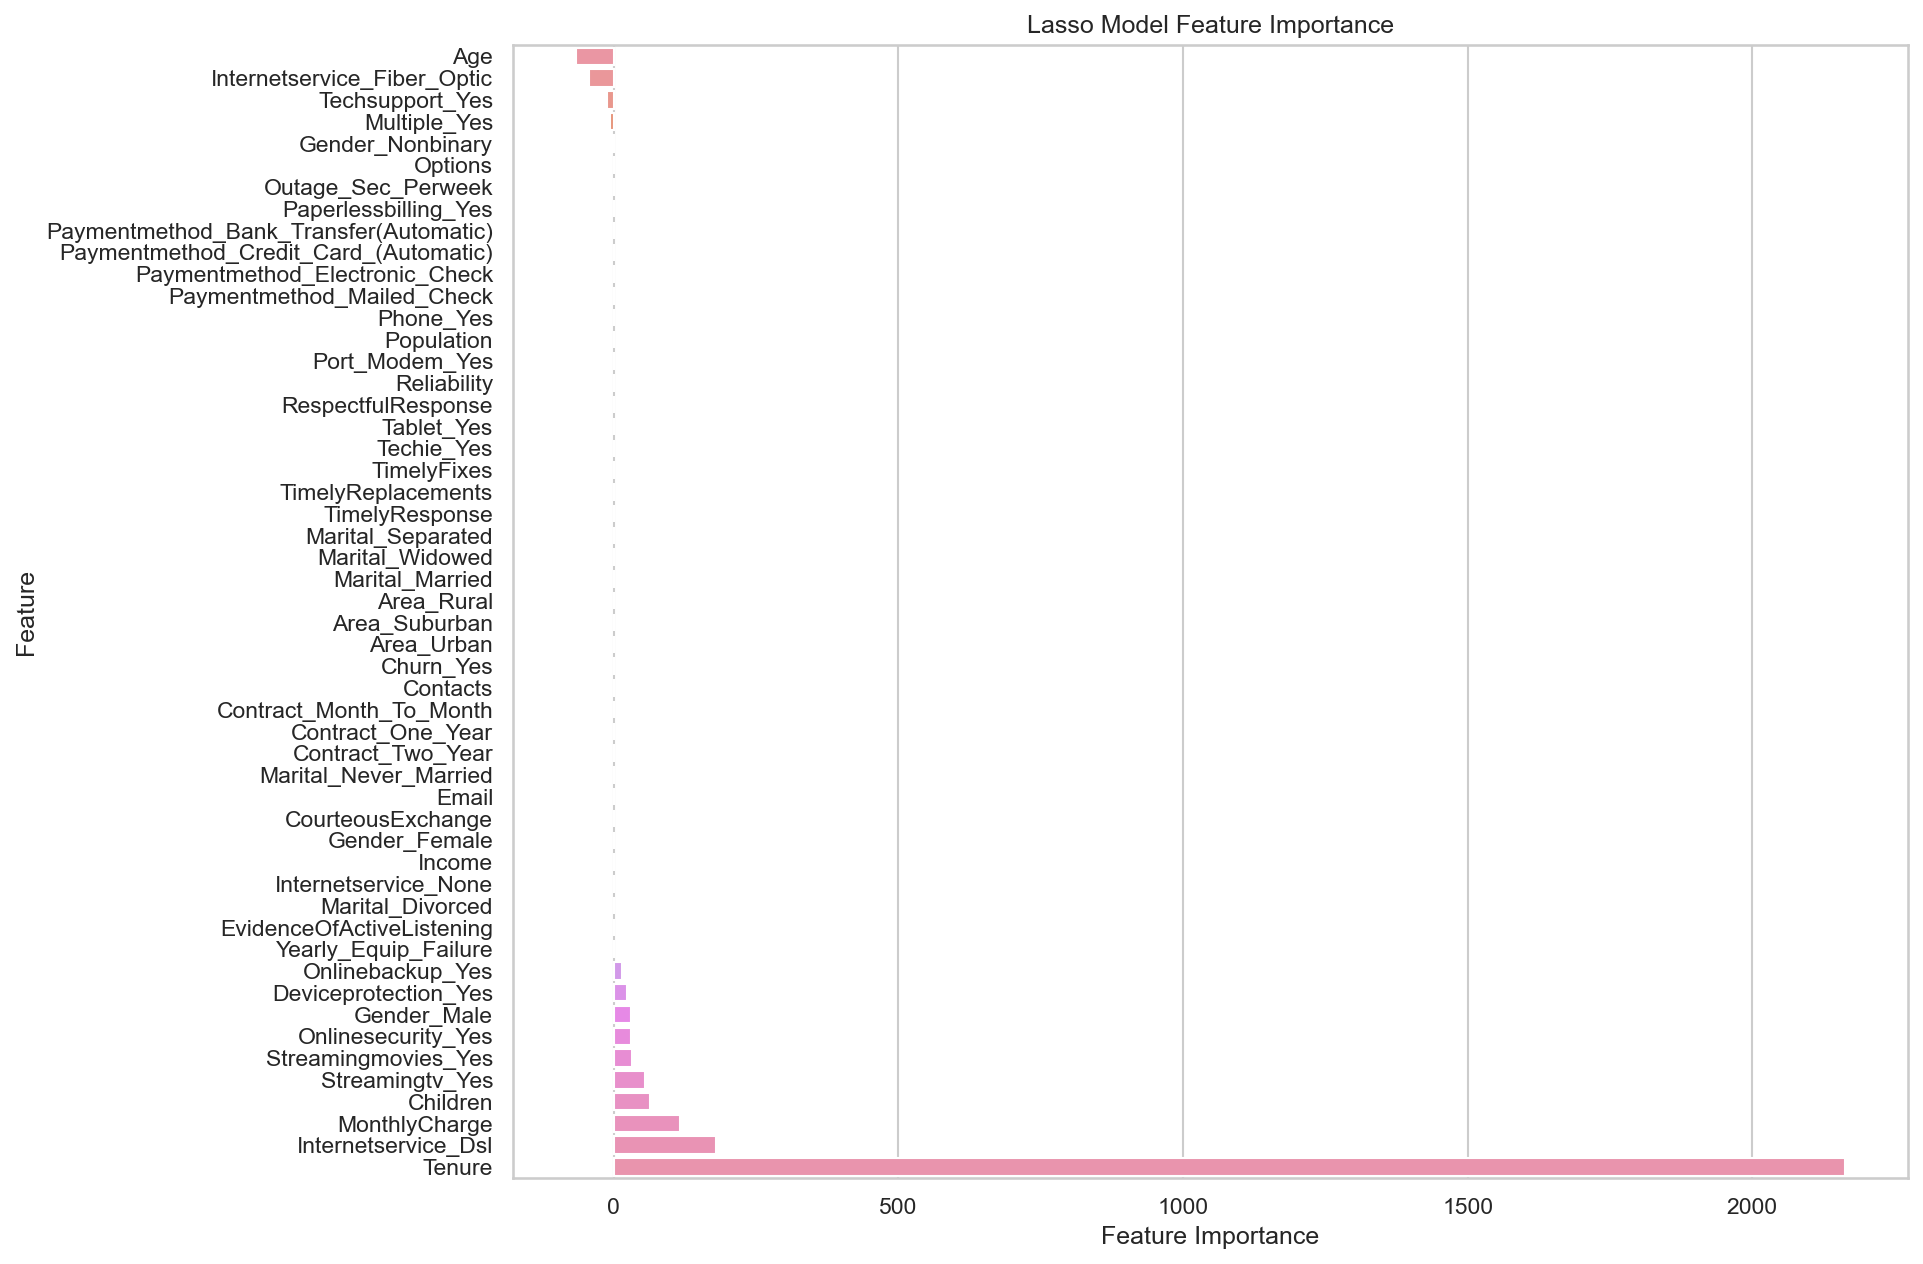

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("scaler", StandardScaler()),
    ("lasso", LassoCV()),    
]

pipeline = Pipeline(steps).fit(X_train, y_train)

reg = pipeline.named_steps.get("lasso")

print("Best alpha using built-in LassoCV:", reg.alpha_)
# coefficient of determination of the prediction.
print("Best score using built-in LassoCV:", reg.score(X_train, y_train))
# The amount of penalization chosen by cross validation.
# print("reg.coef_", reg.coef_)
# print("X_train.columns", X_train.columns)
coef = pd.Series(reg.coef_, index=X_train.columns)

selected_vars = abs(coef) > 0
selected_cols = coef[selected_vars == True].index
# selected_vars =
print("selected cols", selected_cols)
num_selected_vars = sum(selected_vars)

print(
    f"Lasso selected {num_selected_vars} variables and eliminated { sum(abs(coef) == 0) } variables"
)

imp_coef = coef.sort_values()
imp_coef = pd.DataFrame(
    {
        "Feature Importance": imp_coef,
        "Feature Importance (SN)": imp_coef.apply(np.format_float_scientific),
    }
)
imp_coef.reset_index(inplace=True)
imp_coef = imp_coef.rename(columns={"index": "Feature"})

barplot = sns.barplot(data=imp_coef, y="Feature", x="Feature Importance", orient="h")
barplot.set_title("Lasso Model Feature Importance")

imp_coef[abs(imp_coef["Feature Importance"]) > 0]


##### Feature Important LASSO Regression
```
Train MAE: 0.33
Test MAE: 10.86
```

,# Variables,Train MAE,Test MAE,Best Model Params
0,15,0.33,10.86,"{'lasso__alpha': 1, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__positive': False, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': False}"


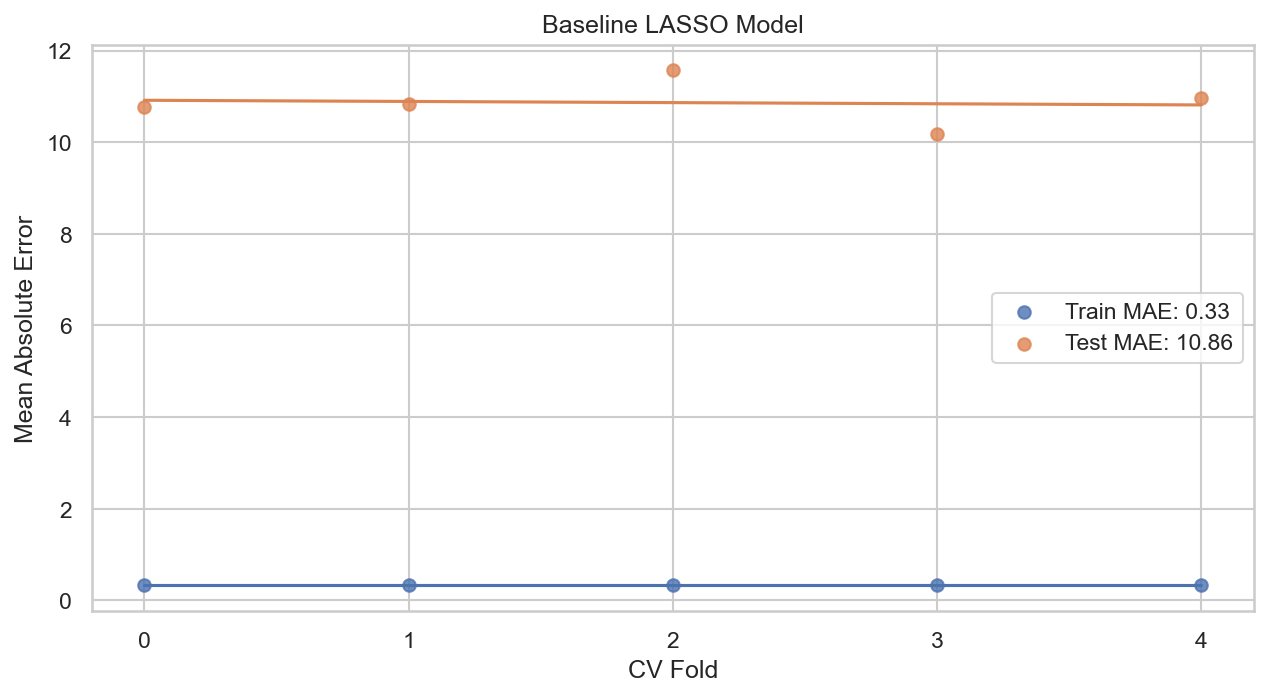

In [41]:
x_cols = ['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male',
       'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes',
       'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes',
       'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure']

X_train, X_test, y_train, y_test = train_test_split(
    X[x_cols], y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [("scaler", StandardScaler()), ("lasso", Lasso(random_state=RANDOM_STATE))]
steps = [("lasso", Lasso(random_state=RANDOM_STATE))]

param_grid = {
    "lasso__alpha": [1],
    "lasso__fit_intercept": [True],
    "lasso__max_iter": [1000],
    "lasso__tol": [1e-4],
    "lasso__warm_start": [False],    
    "lasso__positive": [False],
    "lasso__selection": ["cyclic"],    
}

pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

y_pred = cv.predict(X_test)

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline LASSO Model", xticks=[]
)

In [ ]:
# evaluate an lasso regression model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model
model = Lasso(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
# make a prediction with a lasso regression model on the dataset
from pandas import read_csv
from sklearn.linear_model import Lasso
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model
model = Lasso(alpha=1.0)
# fit model
model.fit(X, y)
# define new data
row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
# make a prediction
yhat = model.predict([row])
# summarize prediction
print('Predicted: %.3f' % yhat)

In [ ]:
# grid search hyperparameters for lasso regression
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

In [ ]:
# The scikit-learn library also provides a built-in version of the algorithm that automatically finds good hyperparameters via the LassoCV class.

# use automatically configured the lasso regression algorithm
from numpy import arange
from pandas import read_csv
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model = LassoCV(alphas=arange(0, 1, 0.01), cv=cv, n_jobs=-1)
# fit model
model.fit(X, y)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

#### Ridge Regression

##### Baseline Ridge Regression
```
Train MAE: 0.00
Test MAE: 8.83
```

,# Variables,Train MAE,Test MAE,Best Model Params
0,52,0.00,8.83,"{'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001}"


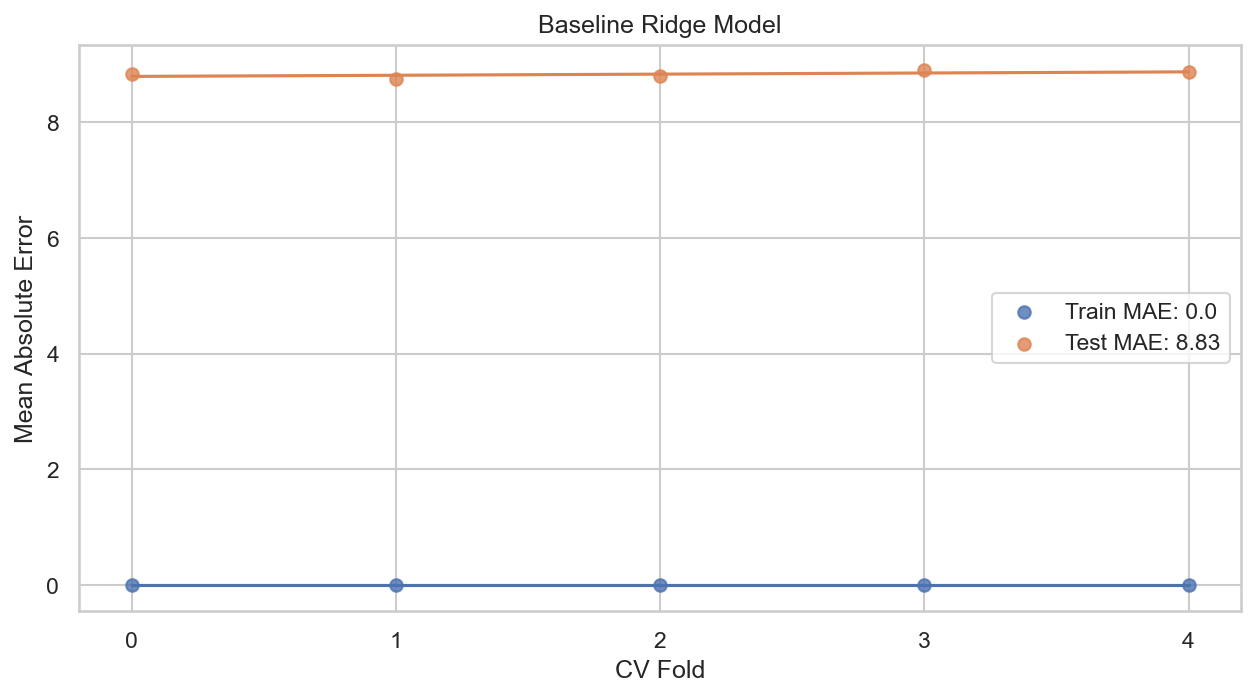

In [31]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [("ridge", Ridge(random_state=RANDOM_STATE))]

param_grid = {
    'ridge__alpha': [1.0],
    'ridge__copy_X': [True],
    'ridge__fit_intercept': [True],
    'ridge__max_iter': [None],
    'ridge__positive': [False],
    'ridge__random_state': [None],
    'ridge__solver': ['auto'],
    'ridge__tol': [0.001 ]   
}

pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

y_pred = cv.predict(X_test)

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline Ridge Model", xticks=[]
)

##### Ridge Feature Importance

Best alpha using built-in LassoCV: 0.1
Best score using built-in LassoCV: -2468.513833763
selected cols Index(['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Female',
       'Gender_Male', 'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'Internetservice_None', 'MonthlyCharge',
       'Multiple_Yes', 'Onlinebackup_Yes', 'Onlinesecurity_Yes',
       'Streamingmovies_Yes', 'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure'],
      dtype='object')
Lasso selected 17 variables and eliminated 0 variables


,Feature,Feature Importance,Feature Importance (SN)
0,Internetservice_Fiber_Optic,-94.89,-9.489230584218922e+01
1,Age,-68.00,-6.799954344209186e+01
2,Internetservice_None,-39.62,-3.9623741204341286e+01
3,Techsupport_Yes,-15.28,-1.528119855278237e+01
4,Gender_Female,-15.03,-1.5033118445983746e+01
5,Multiple_Yes,-11.02,-1.1016424797607897e+01
6,Gender_Nonbinary,-7.80,-7.8022836735704e+00
7,TimelyResponse,-0.18,-1.8138392196738096e-01
8,Paymentmethod_Mailed_Check,-0.16,-1.6135175442377658e-01
9,Churn_Yes,-0.15,-1.480844903421712e-01


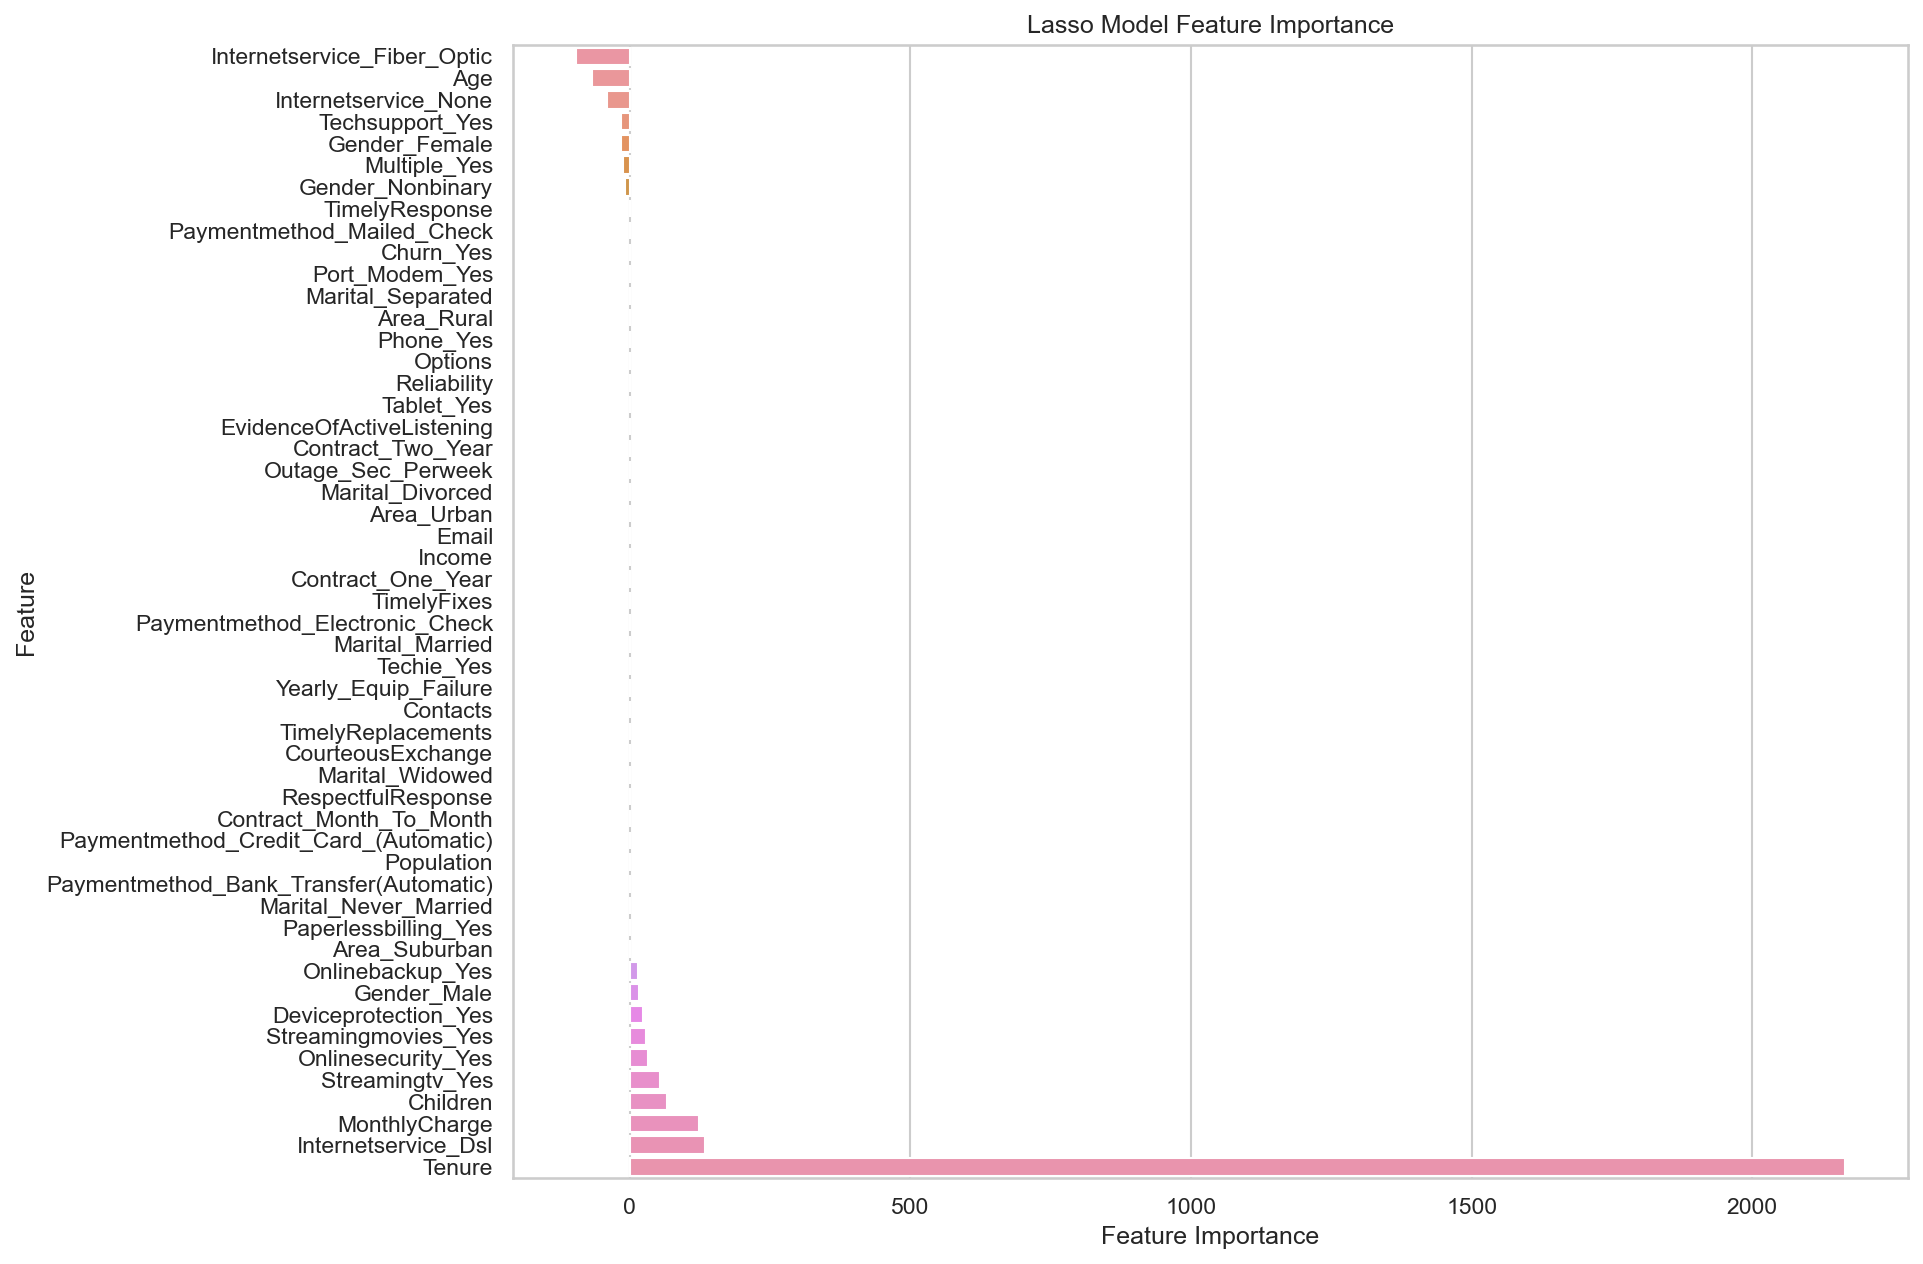

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV()),    
]

pipeline = Pipeline(steps).fit(X_train, y_train)

reg = pipeline.named_steps.get("ridge")

print("Best alpha using built-in LassoCV:", reg.alpha_)
# coefficient of determination of the prediction.
print("Best score using built-in LassoCV:", reg.score(X_train, y_train))
# The amount of penalization chosen by cross validation.
# print("reg.coef_", reg.coef_)
# print("X_train.columns", X_train.columns)
coef = pd.Series(reg.coef_[0], index=X_train.columns)

selected_vars = abs(coef) > 1
selected_cols = coef[selected_vars == True].index
# selected_vars =
print("selected cols", selected_cols)
num_selected_vars = sum(selected_vars)

print(
    f"Lasso selected {num_selected_vars} variables and eliminated { sum(abs(coef) == 0) } variables"
)

imp_coef = coef.sort_values()
imp_coef = pd.DataFrame(
    {
        "Feature Importance": imp_coef,
        "Feature Importance (SN)": imp_coef.apply(np.format_float_scientific),
    }
)
imp_coef.reset_index(inplace=True)
imp_coef = imp_coef.rename(columns={"index": "Feature"})

barplot = sns.barplot(data=imp_coef, y="Feature", x="Feature Importance", orient="h")
barplot.set_title("Lasso Model Feature Importance")

imp_coef[abs(imp_coef["Feature Importance"]) > 0]


##### Feature Important Ridge Regression
```
Train MAE: 0.00
Test MAE: 8.81
```

,# Variables,Train MAE,Test MAE,Best Model Params
0,17,0.00,8.81,"{'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001}"


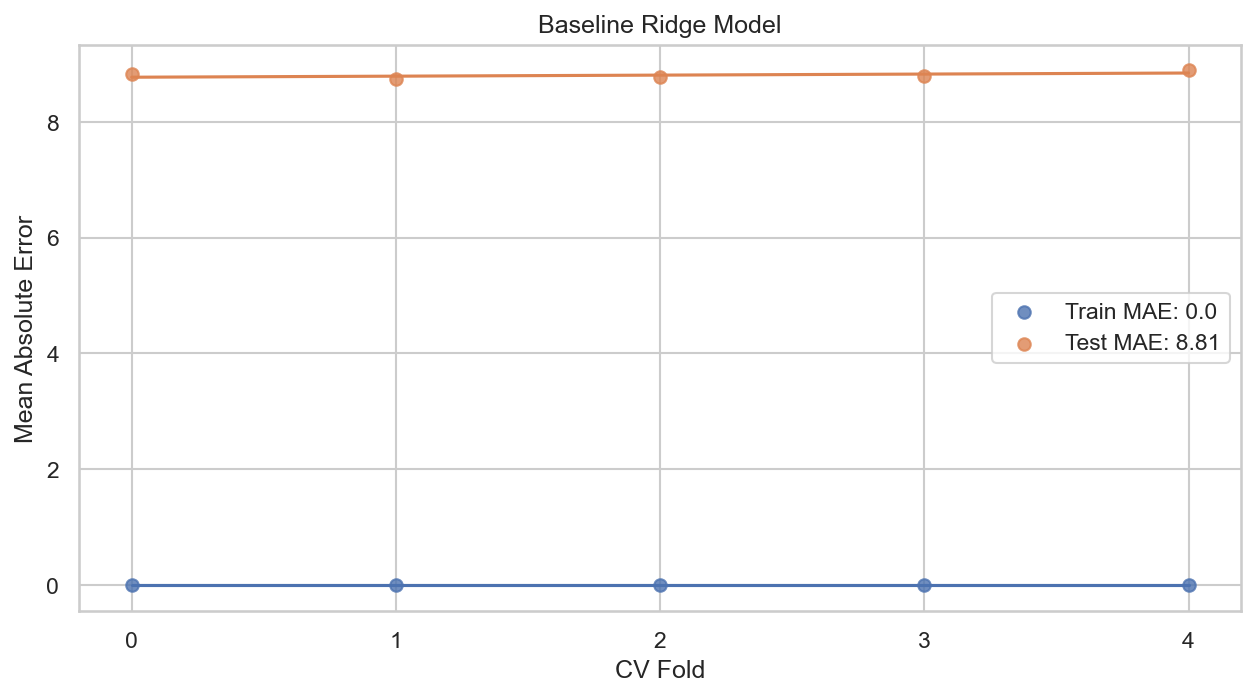

In [39]:
x_cols = ['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Female',
       'Gender_Male', 'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'Internetservice_None', 'MonthlyCharge',
       'Multiple_Yes', 'Onlinebackup_Yes', 'Onlinesecurity_Yes',
       'Streamingmovies_Yes', 'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure']

X_train, X_test, y_train, y_test = train_test_split(
    X[x_cols], y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [("ridge", Ridge(random_state=RANDOM_STATE))]

param_grid = {
    'ridge__alpha': [1.0],
    'ridge__copy_X': [True],
    'ridge__fit_intercept': [True],
    'ridge__max_iter': [None],
    'ridge__positive': [False],
    'ridge__random_state': [None],
    'ridge__solver': ['auto'],
    'ridge__tol': [0.001 ]   
}

pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

y_pred = cv.predict(X_test)

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline Ridge Model", xticks=[]
)

In [ ]:
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
# grid search hyperparameters for ridge regression
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model
model = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

In [ ]:
# The scikit-learn library also provides a built-in version of the algorithm that automatically finds good hyperparameters via the RidgeCV class.

# use automatically configured the ridge regression algorithm
from numpy import arange
from pandas import read_csv
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model = RidgeCV(alphas=arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
# fit model
model.fit(X, y)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

#### ElasticNet Regression

##### Baseline ElasticNet Regression
```
Train MAE: 118.36
Test MAE: 118.29
```

BEST PARAMS {'elasticNet__alpha': 1, 'elasticNet__copy_X': True, 'elasticNet__fit_intercept': True, 'elasticNet__l1_ratio': 0.5, 'elasticNet__max_iter': 1000, 'elasticNet__positive': False, 'elasticNet__precompute': False, 'elasticNet__random_state': None, 'elasticNet__selection': 'cyclic', 'elasticNet__tol': 0.0001, 'elasticNet__warm_start': False}
BEST PARAMS ElasticNet(random_state=1)


,# Variables,Train MAE,Test MAE,Best Model Params
0,52,118.36,118.29,"{'elasticNet__alpha': 1, 'elasticNet__copy_X': True, 'elasticNet__fit_intercept': True, 'elasticNet__l1_ratio': 0.5, 'elasticNet__max_iter': 1000, 'elasticNet__positive': False, 'elasticNet__precompute': False, 'elasticNet__random_state': None, 'elasticNet__selection': 'cyclic', 'elasticNet__tol': 0.0001, 'elasticNet__warm_start': False}"


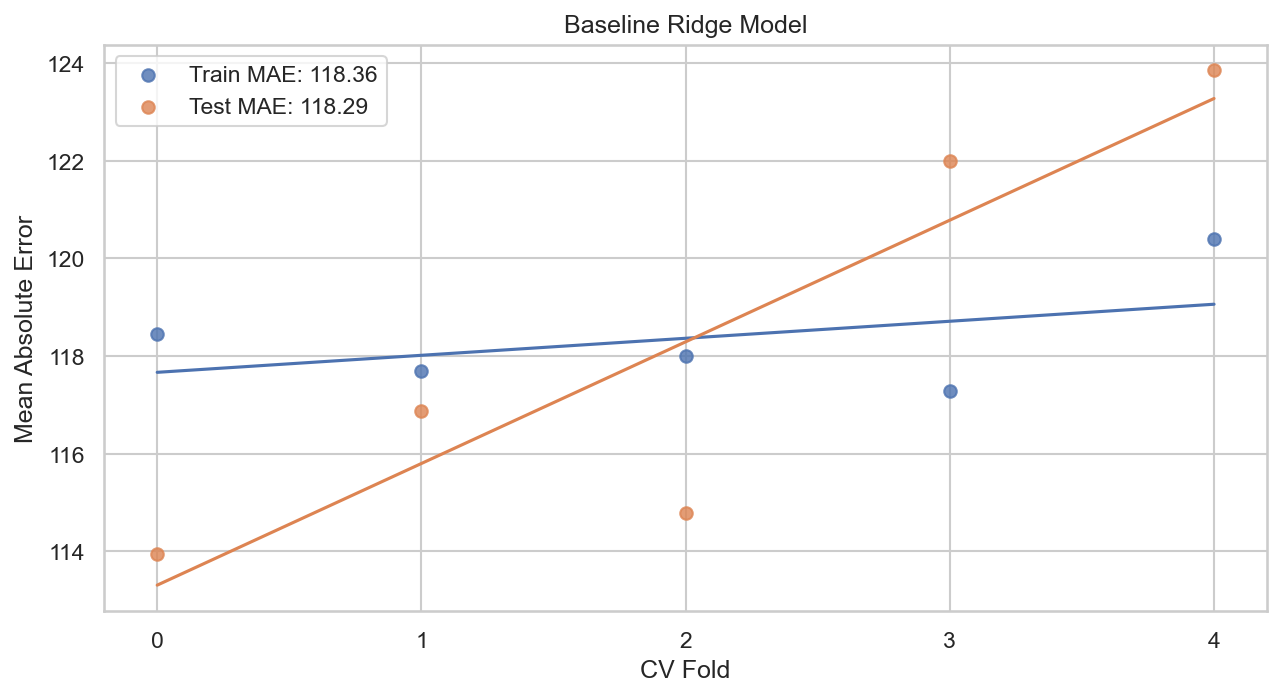

In [75]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV, ElasticNet


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [   
    ("elasticNet", ElasticNet(random_state=RANDOM_STATE))    
]

param_grid = {
    'elasticNet__alpha': [1],
    'elasticNet__copy_X': [True],
    'elasticNet__fit_intercept': [True],
    'elasticNet__l1_ratio': [0.5],
    'elasticNet__max_iter': [1000],
    'elasticNet__positive': [False],
    'elasticNet__precompute': [False],
    'elasticNet__random_state': [None],
    'elasticNet__selection': ['cyclic'],
    'elasticNet__tol': [0.0001],
    'elasticNet__warm_start': [False]
}

pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(elastic_net_pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

print("BEST PARAMS", cv.best_params_)

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline Ridge Model", xticks=[]
)


##### ElasticNet Option Plots

In [221]:
param_grid = {
    'alpha': (np.arange(.1, 1.5, .05), "Constant that multiplies the penalty terms. Defaults to 1.0. See the notes for the exact mathematical meaning of this parameter. alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object. For numerical reasons, using alpha = 0 with the Lasso object is not advised. Given this, you should use the LinearRegression object." ),
    'l1_ratio': (np.arange(.1, 1, .05), "The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2."),
    'max_iter': ([500, 1100, 1000], "The maximum number of iterations."),
    'positive': ([True,False], "When set to True, forces the coefficients to be positive."),
    'precompute': ([False, True], "Whether to use a precomputed Gram matrix to speed up calculations. The Gram matrix can also be passed as argument. For sparse input this option is always False to preserve sparsity."),
    'selection': (['cyclic', 'random'], "If set to ‘random’, a random coefficient is updated every iteration rather than looping over features sequentially by default. This (setting to ‘random’) often leads to significantly faster convergence especially when tol is higher than 1e-4." ),
    'tol': ([0.0001], "The tolerance for the optimization: if the updates are smaller than tol, the optimization code checks the dual gap for optimality and continues until it is smaller than tol, see Notes below."),
}

for option_key, (options, param_desc) in param_grid.items():
    print(f"Plotting '{option_key}' Option Scores")
    print("*" * 50)
    
    default_param_grid = {
        'elasticNet__alpha': [1],
        'elasticNet__copy_X': [True],
        'elasticNet__fit_intercept': [True],
        'elasticNet__l1_ratio': [0.5],
        'elasticNet__max_iter': [1000],
        'elasticNet__positive': [False],
        'elasticNet__precompute': [False],
        'elasticNet__random_state': [RANDOM_STATE],
        'elasticNet__selection': ['cyclic'],
        'elasticNet__tol': [0.0001],
        'elasticNet__warm_start': [False]
    }    
    
    lib.plot_param_options_accuracy(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        param_grid=default_param_grid,
        options=options,
        step="elasticNet",
        options_key=pipeline,
        pipeline=cv,
        param_desc=param_desc,
    )    



Plotting 'alpha' Option Scores
**************************************************


KeyboardInterrupt: 

##### ElasticNet Regression + GridSearchCV
```
Train MAE: 8.95
Test MAE: 8.94
```

BEST PARAMS {'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.9500000000000003, 'elasticNet__positive': False}


,# Variables,Train MAE,Test MAE,Best Model Params
0,52,8.95,8.92,"{'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.9500000000000003, 'elasticNet__positive': False}"


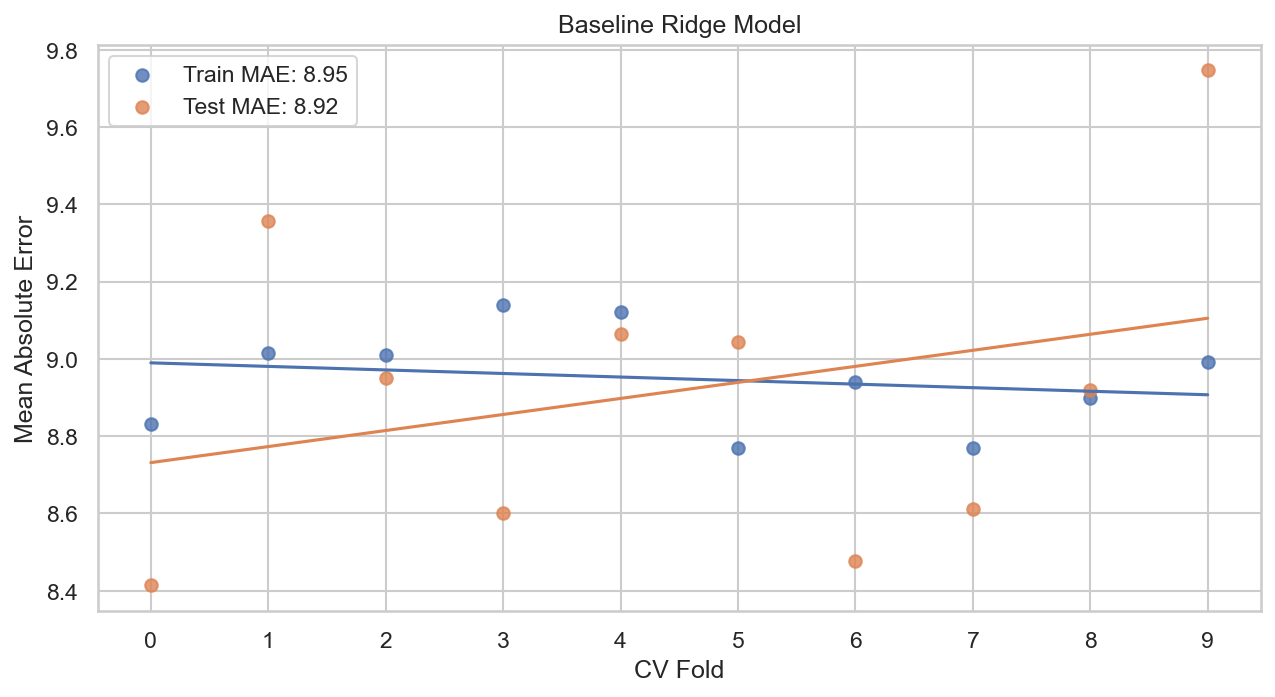

In [220]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV, ElasticNet


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [ 
    ("elasticNet", ElasticNet(random_state=RANDOM_STATE))    
]

param_grid = {
    'elasticNet__alpha': np.arange(.1, 1, .05),
    'elasticNet__l1_ratio': np.arange(.1, 1, .05),    
    'elasticNet__positive': [True, False],
}

elastic_net_pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(elastic_net_pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline Ridge Model", xticks=[]
)


##### ElasticNet Regression + Imputation + Scaling + GridSearchCV
```
Train MAE: 22.55
Test MAE: 23.04
```

BEST PARAMS {'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.9}
BEST PARAMS ElasticNet(random_state=1)


,# Variables,Train MAE,Test MAE,Best Model Params
0,52,22.55,23.04,"{'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.9}"


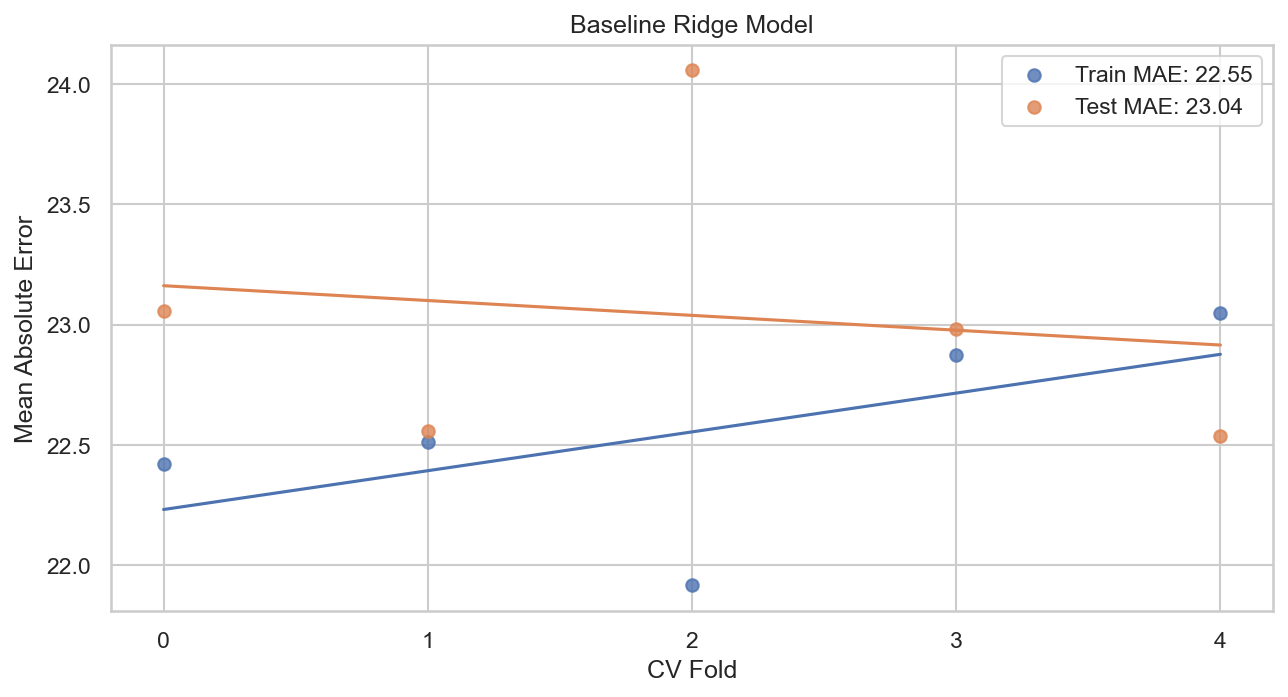

In [125]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV, ElasticNet


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("imp", SimpleImputer(missing_values=np.nan)),
    ("scaler", StandardScaler()),  
    ("elasticNet", ElasticNet(random_state=RANDOM_STATE))    
]

param_grid = {
    'elasticNet__alpha': np.arange(.1, 1, .1),
    'elasticNet__l1_ratio': np.arange(.1, 1, .1),    
}


elastic_net_pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(elastic_net_pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

print("BEST PARAMS", cv.best_params_)

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline Ridge Model", xticks=[]
)


##### ElasticNet Regression + Imputation + GridSearchCV
```
Train MAE: 9.96
Test MAE: 10.15	
```

BEST PARAMS {'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.9}
BEST ESTIMATOR ElasticNet(random_state=1)


,# Variables,Train MAE,Test MAE,Best Model Params
0,52,9.96,10.15,"{'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.9}"


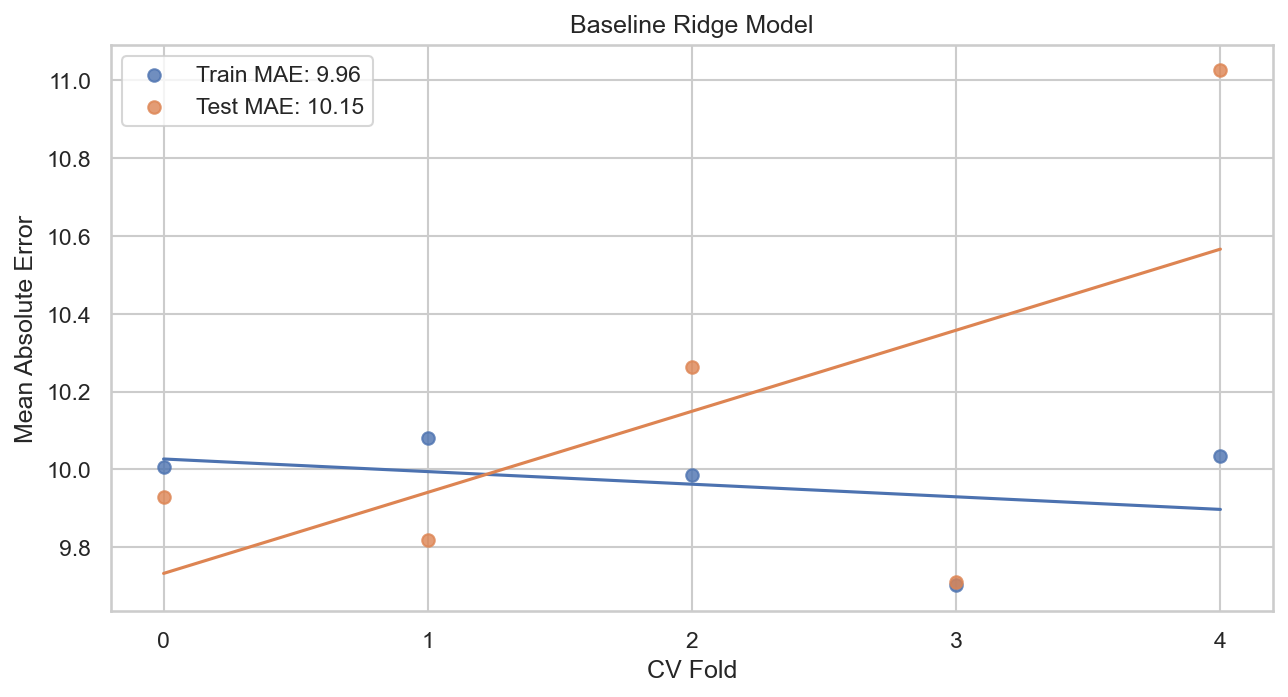

In [131]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV, ElasticNet


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("imp", SimpleImputer(missing_values=np.nan)),    
    ("elasticNet", ElasticNet(random_state=RANDOM_STATE))    
]

param_grid = {
    'elasticNet__alpha': np.arange(.1, 1.5, .1),
    'elasticNet__l1_ratio': np.arange(.1, 1, .1),    
}

elastic_net_pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(elastic_net_pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

print("BEST PARAMS", cv.best_params_)
print("BEST ESTIMATOR", cv.estimator.named_steps["elasticNet"])

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline Ridge Model", xticks=[]
)


##### ElasticNet Regression + Imputation + LASSO Selection + GridSearchCV
```
Train MAE: 11.32
Test MAE: 11.47
```

BEST PARAMS {'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.8999999999999999}
BEST ESTIMATOR ElasticNet(random_state=1)


,# Variables,Train MAE,Test MAE,Best Model Params,Imp. Feats.,# Imp. Feats.
0,52,11.32,11.47,"{'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.8999999999999999}","[Age, Children, Deviceprotection_Yes, Gender_Male, Internetservice_Dsl, Internetservice_Fiber_Optic, MonthlyCharge, Multiple_Yes, Onlinebackup_Yes, Onlinesecurity_Yes, Streamingmovies_Yes, Streamingtv_Yes, Techsupport_Yes, Tenure]",14


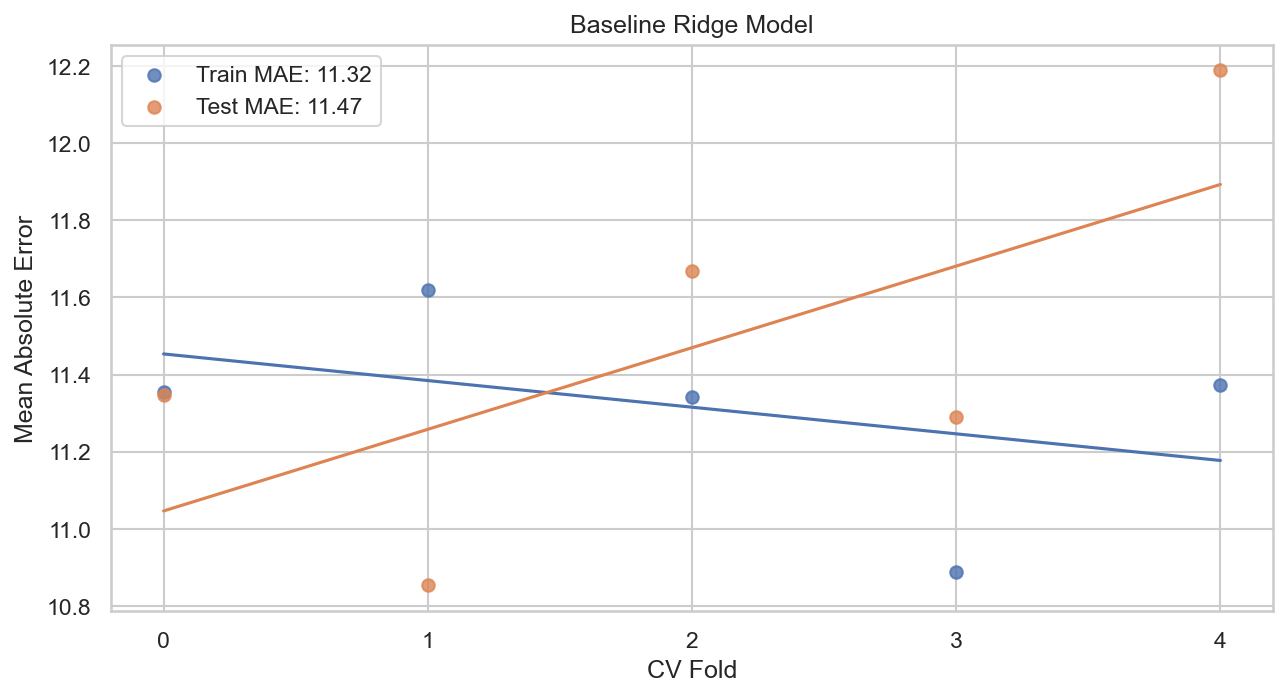

In [175]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV, ElasticNet

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("imp", SimpleImputer(missing_values=np.nan)),
    ("feature_selection", SelectFromModel(Lasso())),    
    ("elasticNet", ElasticNet(random_state=RANDOM_STATE))    
]

param_grid = {
    'elasticNet__alpha': np.arange(.1, 1.5, .1),
    'elasticNet__l1_ratio': np.arange(.1, 1, .1),    
}

param_grid = {
    'elasticNet__alpha': np.arange(.1, .5, .1),
    'elasticNet__l1_ratio': np.arange(.5, 1, .1),    
}

elastic_net_pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(elastic_net_pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

print("BEST PARAMS", cv.best_params_)
print("BEST ESTIMATOR", cv.estimator.named_steps["elasticNet"])

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline Ridge Model", xticks=[]
)


##### ElasticNet Regression + Imputation + Ridge Selection + GridSearchCV
```
Train MAE: 63.29
Test MAE: 61.00
```

BEST PARAMS {'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.9}
BEST ESTIMATOR ElasticNet(random_state=1)


,# Variables,Train MAE,Test MAE,Best Model Params,Imp. Feats.,# Imp. Feats.
0,52,63.29,61.00,"{'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.9}","[Children, Deviceprotection_Yes, Gender_Male, Gender_Nonbinary, Internetservice_Dsl, Internetservice_Fiber_Optic, Internetservice_None, Multiple_Yes, Onlinebackup_Yes, Onlinesecurity_Yes, Streamingmovies_Yes, Streamingtv_Yes, Techsupport_Yes, Tenure]",14


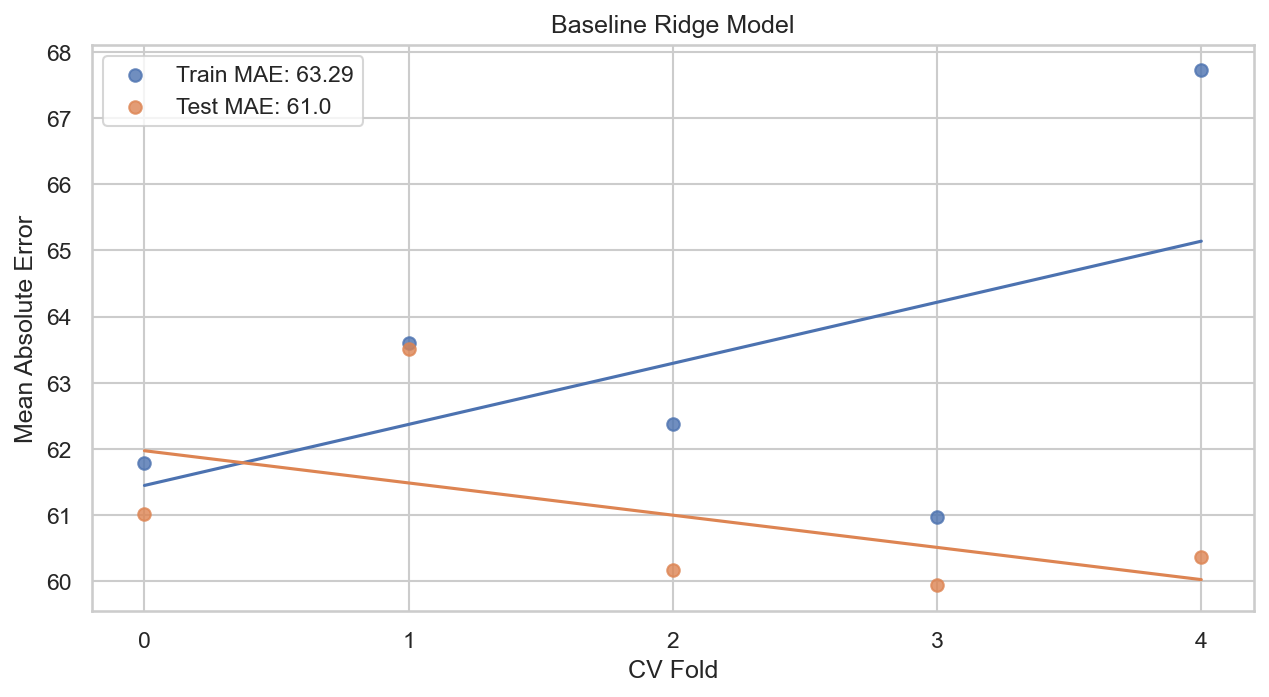

In [133]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV, ElasticNet


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("imp", SimpleImputer(missing_values=np.nan)),   
    ("feature_selection", SelectFromModel(Ridge())),    
    ("elasticNet", ElasticNet(random_state=RANDOM_STATE))    
]

param_grid = {
    'elasticNet__alpha': np.arange(.1, 1.5, .1),
    'elasticNet__l1_ratio': np.arange(.1, 1, .1),    
}

elastic_net_pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(elastic_net_pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

print("BEST PARAMS", cv.best_params_)
print("BEST ESTIMATOR", cv.estimator.named_steps["elasticNet"])

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline Ridge Model", xticks=[]
)


In [ ]:
# threshold = np.sort(importance)[-3] + 0.01

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(ridge.coef_)[0]
feature_names = np.array(X.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.xticks(rotation = 90)
plt.show()

threshold = np.sort(importance)[-11] + 0.01

sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")


In [ ]:
# cv.estimator.named_steps.get("elasticNet").feature_names_in_
print(pipeline[:-1].get_feature_names_out())

feature_importance = pd.Series(index = pipeline[:-1].get_feature_names_out(), data = cv.estimator.named_steps.get("elasticNet").coef_)

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))

##### ElasticNet Feature Importance

In [62]:
from sklearn.linear_model import LinearRegression

X = df.drop(TARGET_VAR, axis=1)
y = df[[TARGET_VAR]]

x_cols = ['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male',
       'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes',
       'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes',
       'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure']

X_train, X_test, y_train, y_test = train_test_split(
    X[x_cols], y, test_size=0.2, random_state=RANDOM_STATE
)

reg = LinearRegression().fit(X_train, y_train)

scores = cross_val_score(reg, X_test, y_test, scoring='neg_mean_absolute_error', n_jobs=-1)

# force scores to be positive
scores = abs(scores)
print(f'Mean MAE: {rnd(mean(scores))} MAE Std. Dev: {stdev(scores)})')
reg.score(X_test, y_test)

plt.scatter(X.Internetservice_Fiber_Optic.sample(n=100, random_state=RANDOM_STATE), y.sample(n=100, random_state=RANDOM_STATE))
plt.ylabel(TARGET_VAR)
plt.xlabel('Age')
plt.show();

Mean MAE: 8.81 MAE Std. Dev: 0.051007212645474226)


Best alpha using built-in LassoCV: 4.326519732206713
Best score using built-in LassoCV: -230.7853406169246
selected cols Index(['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male',
       'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes',
       'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes',
       'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure'],
      dtype='object')
Lasso selected 15 variables and eliminated 0 variables
Optimal alpha: 4.32651973
Optimal l1_ratio: 0.500
Number of iterations 5


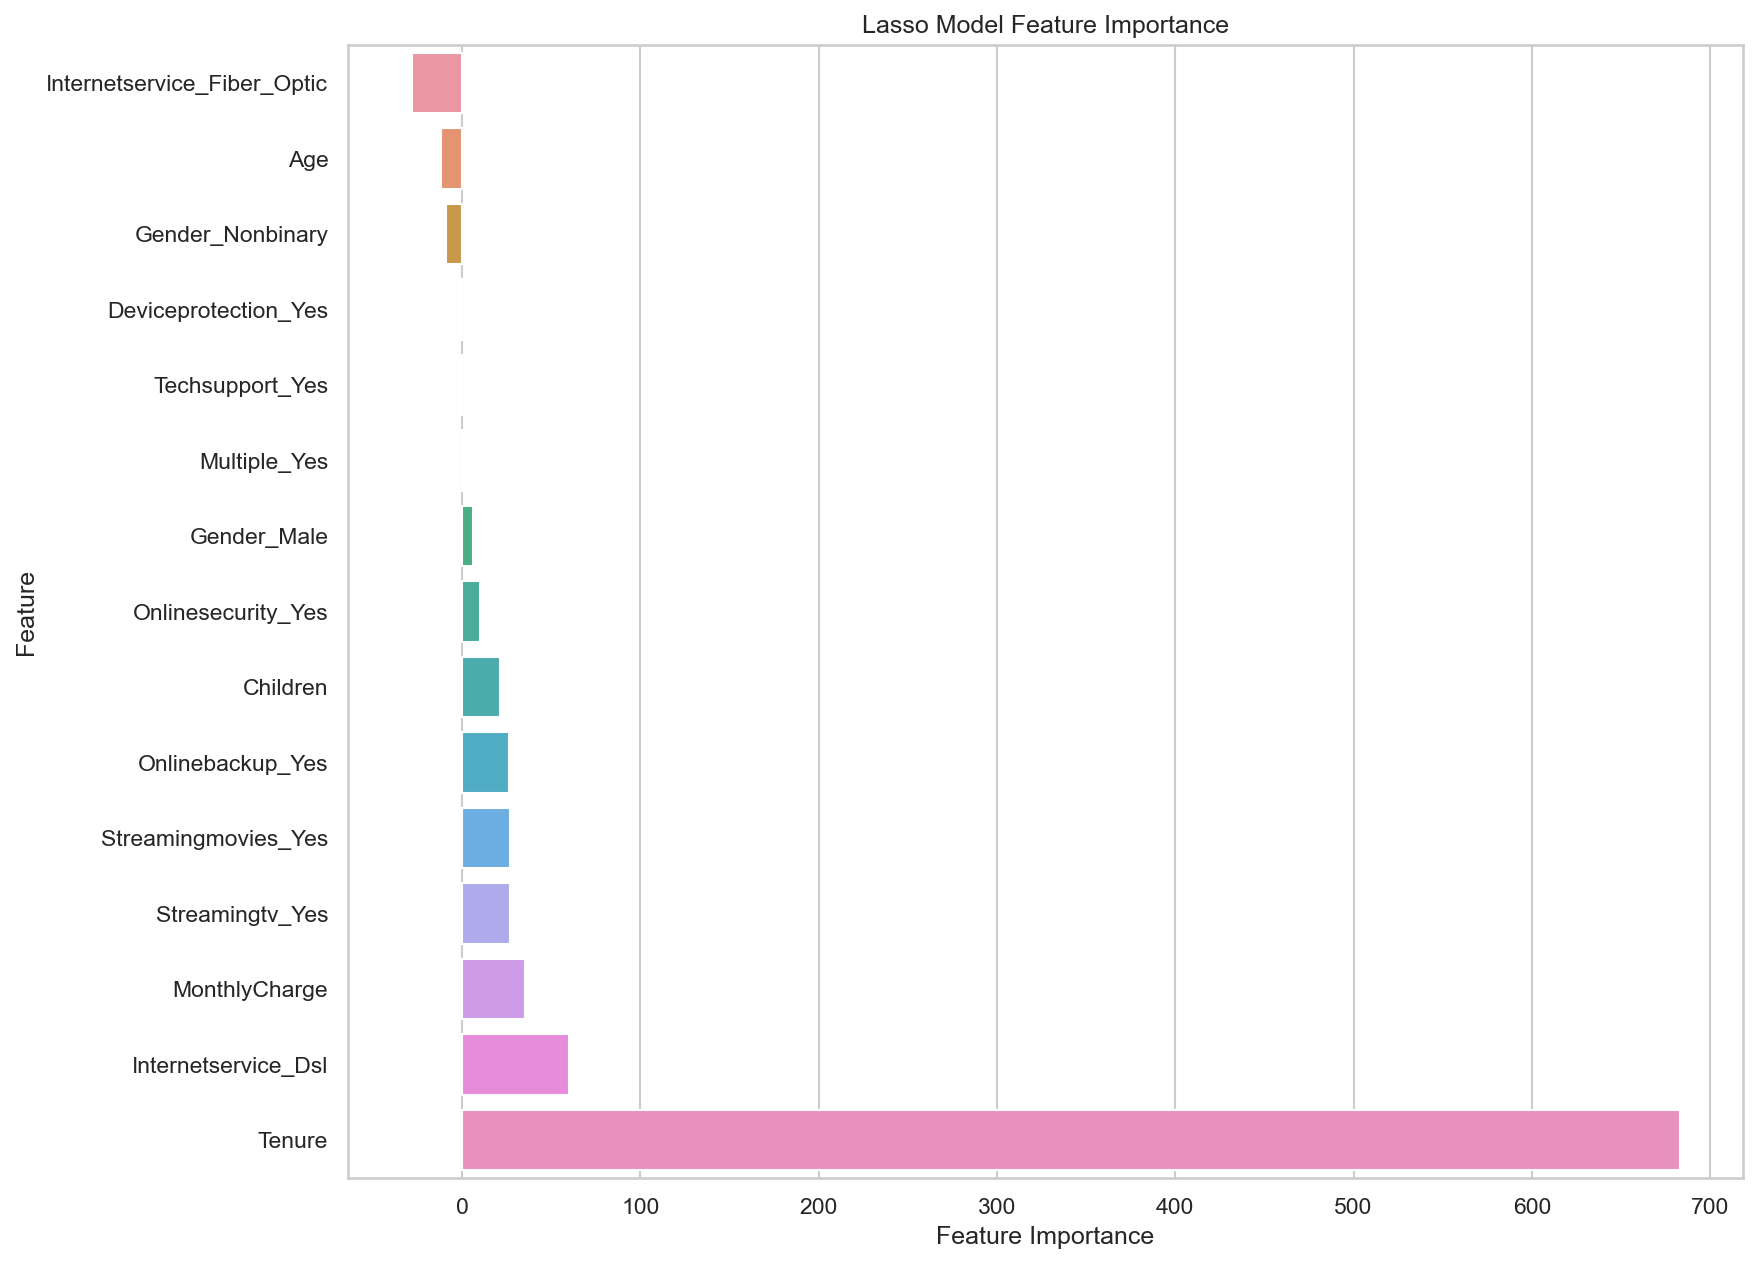

In [135]:
x_cols = ['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male',
       'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes',
       'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes',
       'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("scaler", StandardScaler()),
    # ("lasso", LassoCV()),
    ("elasticNet", ElasticNetCV()),    
]

pipeline = Pipeline(steps).fit(X_train[x_cols], y_train)

reg = pipeline.named_steps.get("elasticNet")

print("Best alpha using built-in LassoCV:", reg.alpha_)
# coefficient of determination of the prediction.
print("Best score using built-in LassoCV:", reg.score(X_train[x_cols], y_train))
# The amount of penalization chosen by cross validation.
# print("reg.coef_", reg.coef_)
# print("X_train.columns", X_train.columns)
coef = pd.Series(reg.coef_[0], index=X_train.columns)
coef = pd.Series(reg.coef_[0], index=x_cols)

coef= pd.Series(reg.coef_, x_cols)

# cv.estimator.named_steps.get("elasticNet").coef_

selected_vars = abs(coef) > 0
selected_cols = coef[selected_vars == True].index
# selected_vars =
print("selected cols", selected_cols)
num_selected_vars = sum(selected_vars)

print(
    f"Lasso selected {num_selected_vars} variables and eliminated { sum(abs(coef) == 0) } variables"
)

imp_coef = coef.sort_values()
imp_coef = pd.DataFrame(
    {
        "Feature Importance": imp_coef,
        "Feature Importance (SN)": imp_coef.apply(np.format_float_scientific),
    }
)
imp_coef.reset_index(inplace=True)
imp_coef = imp_coef.rename(columns={"index": "Feature"})

barplot = sns.barplot(data=imp_coef, y="Feature", x="Feature Importance", orient="h")
barplot.set_title("Lasso Model Feature Importance")

imp_coef[abs(imp_coef["Feature Importance"]) > 0]

print('Optimal alpha: %.8f'%reg.alpha_)
print('Optimal l1_ratio: %.3f'%reg.l1_ratio_)
print('Number of iterations %d'%reg.n_iter_)


BEST PARAMS {'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.9}
BEST ESTIMATOR ElasticNet(random_state=1)


,# Variables,Train MAE,Test MAE,Best Model Params
0,14,11.32,11.44,"{'elasticNet__alpha': 0.1, 'elasticNet__l1_ratio': 0.9}"


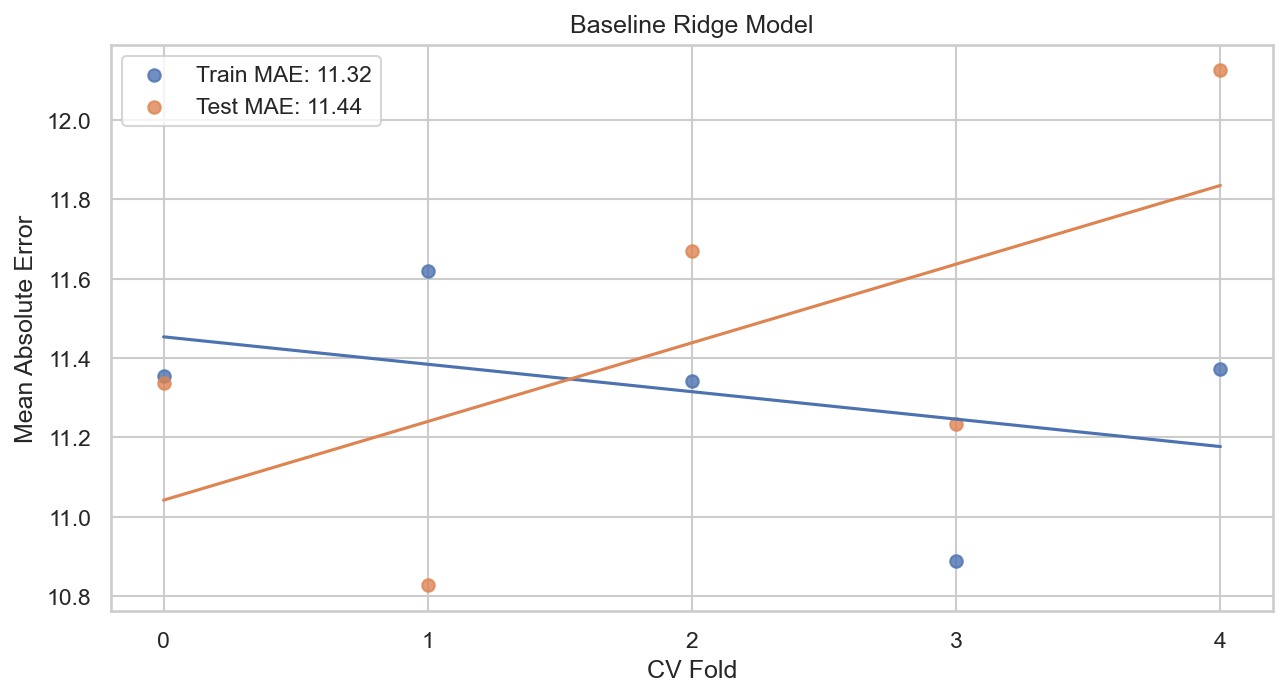

In [144]:

# 11.32	11.44
lasso_x_cols = ["Age", "Children", "Deviceprotection_Yes", "Gender_Male", "Internetservice_Dsl", "Internetservice_Fiber_Optic", "MonthlyCharge", "Multiple_Yes", "Onlinebackup_Yes", "Onlinesecurity_Yes", "Streamingmovies_Yes", "Streamingtv_Yes", "Techsupport_Yes", "Tenure"]

# 62.22 61.00
ridge_x_cols =  ["Children", "Deviceprotection_Yes", "Gender_Male", "Gender_Nonbinary", "Internetservice_Dsl", "Internetservice_Fiber_Optic", "Internetservice_None", "Multiple_Yes", "Onlinebackup_Yes", "Onlinesecurity_Yes", "Streamingmovies_Yes", "Streamingtv_Yes", "Techsupport_Yes", "Tenure"]

# 11.11 11.25
elastic_net_x_cols = ['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male',
       'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes',
       'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes',
       'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure']


X_train, X_test, y_train, y_test = train_test_split(
    X[lasso_x_cols], y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("imp", SimpleImputer(missing_values=np.nan)),   
    # ("feature_selection", SelectFromModel(Ridge())),    
    ("elasticNet", ElasticNet(random_state=RANDOM_STATE))    
]

param_grid = {
    'elasticNet__alpha': np.arange(.1, 1, .1),
    'elasticNet__l1_ratio': np.arange(.1, 1, .1),    
}

elastic_net_pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(elastic_net_pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

print("BEST PARAMS", cv.best_params_)
print("BEST ESTIMATOR", cv.estimator.named_steps["elasticNet"])

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline Ridge Model", xticks=[]
)


In [ ]:
# evaluate an elastic net model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
# make a prediction with an elastic net model on the dataset
from pandas import read_csv
from sklearn.linear_model import ElasticNet
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# fit model
model.fit(X, y)
# define new data
row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
# make a prediction
yhat = model.predict([row])
# summarize prediction
print('Predicted: %.3f' % yhat)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')


# grid search hyperparameters for the elastic net
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=4, n_repeats=3, random_state=1)
# define grid
grid = dict()
# grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['alpha'] = [1e-2]
grid['l1_ratio'] = arange(0, 1, 0.01)
grid['random_state'] = [1]
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

# GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
#              estimator=ElasticNet(),
#              param_grid={'alpha': [0.01], 'fit_intercept': [True],
#                          'l1_ratio': [0.75, 0.8, 0.85, 0.9],
#                          'max_iter': range(350, 450, 50), 'normalize': [False],
#                          'random_state': [3], 'selection': ['random'],
#                          'tol': [0.1]},
#              refit='nmse', return_train_score=True,
#              scoring={'mae': 'neg_mean_absolute_error',
#                       'nmse': 'neg_mean_squared_error',
#                       'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})

##### Feature Important ElasticNet Regression
```
Train MAE: 0.33
Test MAE: 121.43
```

BEST PARAMS {'elasticNet__alpha': 1, 'elasticNet__copy_X': True, 'elasticNet__fit_intercept': True, 'elasticNet__l1_ratio': 0.5, 'elasticNet__max_iter': 1000, 'elasticNet__positive': False, 'elasticNet__precompute': False, 'elasticNet__random_state': None, 'elasticNet__selection': 'cyclic', 'elasticNet__tol': 0.0001, 'elasticNet__warm_start': False}
BEST PARAMS ElasticNet(random_state=1)


,# Variables,Train MAE,Test MAE,Best Model Params
0,15,1.93,699.87,"{'elasticNet__alpha': 1, 'elasticNet__copy_X': True, 'elasticNet__fit_intercept': True, 'elasticNet__l1_ratio': 0.5, 'elasticNet__max_iter': 1000, 'elasticNet__positive': False, 'elasticNet__precompute': False, 'elasticNet__random_state': None, 'elasticNet__selection': 'cyclic', 'elasticNet__tol': 0.0001, 'elasticNet__warm_start': False}"


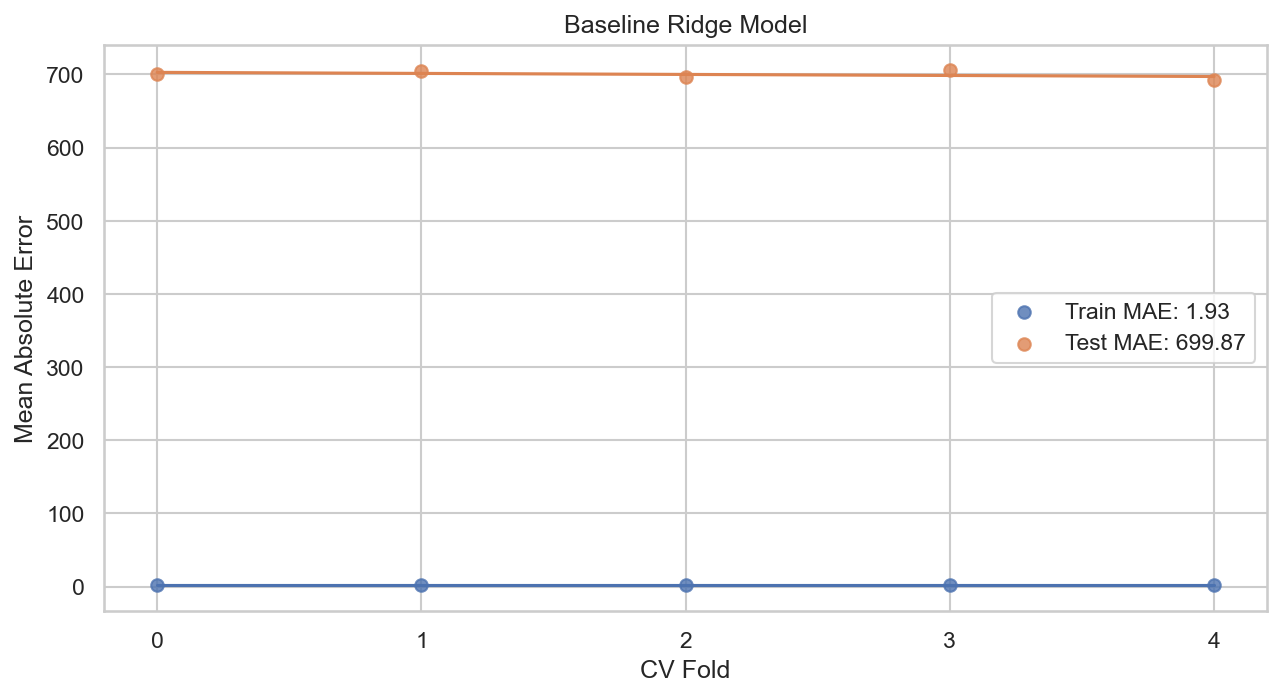

In [64]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV, ElasticNet

x_cols = ['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male',
       'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes',
       'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes',
       'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure']

X_train, X_test, y_train, y_test = train_test_split(
    X[x_cols], y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("imp", SimpleImputer(missing_values=np.nan)),
    ("scaler", StandardScaler()),
    # ("feature_selection", SelectFromModel(Lasso())),    
    # ("feature_selection", SelectFromModel(Ridge())),    
        # ("feature_selection", SelectFromModel(ElasticNet())),    
    ("elasticNet", ElasticNet(random_state=RANDOM_STATE))    
]

# Optimal alpha: 4.32651973
# Optimal l1_ratio: 0.500
# Number of iterations 5

param_grid = {
    'elasticNet__alpha': [1],
    'elasticNet__copy_X': [True],
    'elasticNet__fit_intercept': [True],
    'elasticNet__l1_ratio': [0.5],
    'elasticNet__max_iter': [1000],
    'elasticNet__positive': [False],
    'elasticNet__precompute': [False],
    'elasticNet__random_state': [None],
    'elasticNet__selection': ['cyclic'],
    'elasticNet__tol': [0.0001],
    'elasticNet__warm_start': [False]
}

# param_grid = {
#     'elasticNet__alpha': [0.1, .25, .5, .75, 1.0],
#     'elasticNet__copy_X': [True],
#     'elasticNet__fit_intercept': [True],
#     'elasticNet__l1_ratio': [0.25, 0.5, 0.75, 0.95],
#     'elasticNet__max_iter': [1000],
#     'elasticNet__positive': [False],
#     'elasticNet__precompute': [False],
#     'elasticNet__selection': ['cyclic'],
#     'elasticNet__tol': [0.0001, 0.001, 0.01, 0.1],
#     'elasticNet__warm_start': [False]
# }



pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

y_pred = cv.predict(X_test)

print("BEST PARAMS", cv.best_params_)
print("BEST PARAMS", cv.estimator.named_steps["elasticNet"])

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline Ridge Model", xticks=[]
)



##### Correlation: LinearSVC Pipeline Reduced Features

['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male', 'Gender_Nonbinary', 'Internetservice_Dsl', 'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes', 'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes', 'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure']


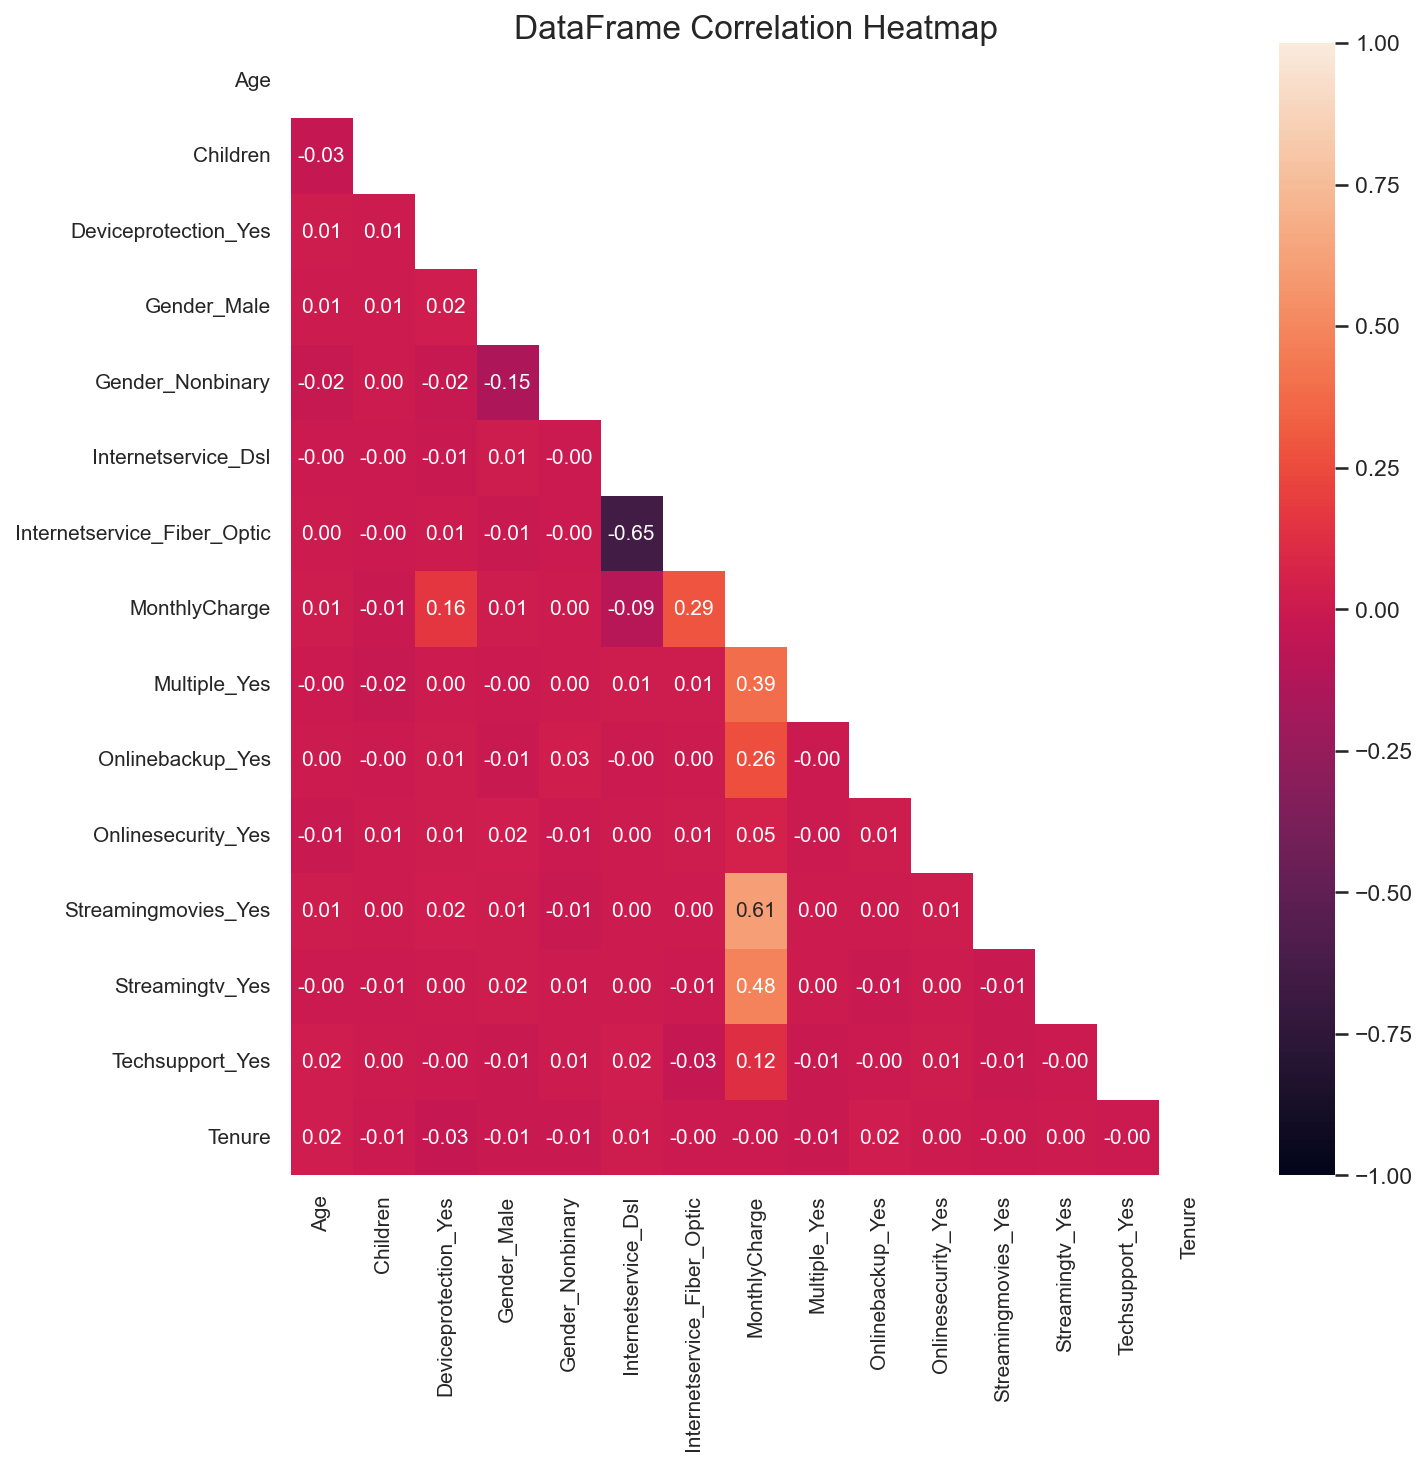

In [172]:
# reduced based on LinearSVC in model pipeline
elastic_net_x_cols = ['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male',
       'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes',
       'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes',
       'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure']

# elastic_net_x_cols.remove("Internetservice_Dsl")
# elastic_net_x_cols.remove("Multiple_Yes")
# elastic_net_x_cols.remove("Streamingmovies_Yes")
# elastic_net_x_cols.remove("Streamingtv_Yes")

print(elastic_net_x_cols)



lib.create_heatmap(df[elastic_net_x_cols], fontsize=10, figsize=(10, 10), title_fontsize=16)
plt.show()

# X_train, X_test, y_train, y_test = train_test_split(
#     X[x_cols], y, test_size=0.2, random_state=RANDOM_STATE
# )
# _ = lib.plot_lasso_feature_importance(X_train, y_train)


##### Remove highly correlated features

BEST PARAMS {'elasticNet__alpha': 0.05, 'elasticNet__l1_ratio': 0.9500000000000004}
BEST ESTIMATOR ElasticNet(random_state=1)


,# Variables,Train MAE,Test MAE,Best Model Params,Imp. Feats.,# Imp. Feats.
0,15,9.07,9.04,"{'elasticNet__alpha': 0.05, 'elasticNet__l1_ratio': 0.9500000000000004}","[Age, Children, Deviceprotection_Yes, Gender_Male, Internetservice_Dsl, Internetservice_Fiber_Optic, MonthlyCharge, Multiple_Yes, Onlinebackup_Yes, Onlinesecurity_Yes, Streamingmovies_Yes, Streamingtv_Yes, Techsupport_Yes, Tenure]",14


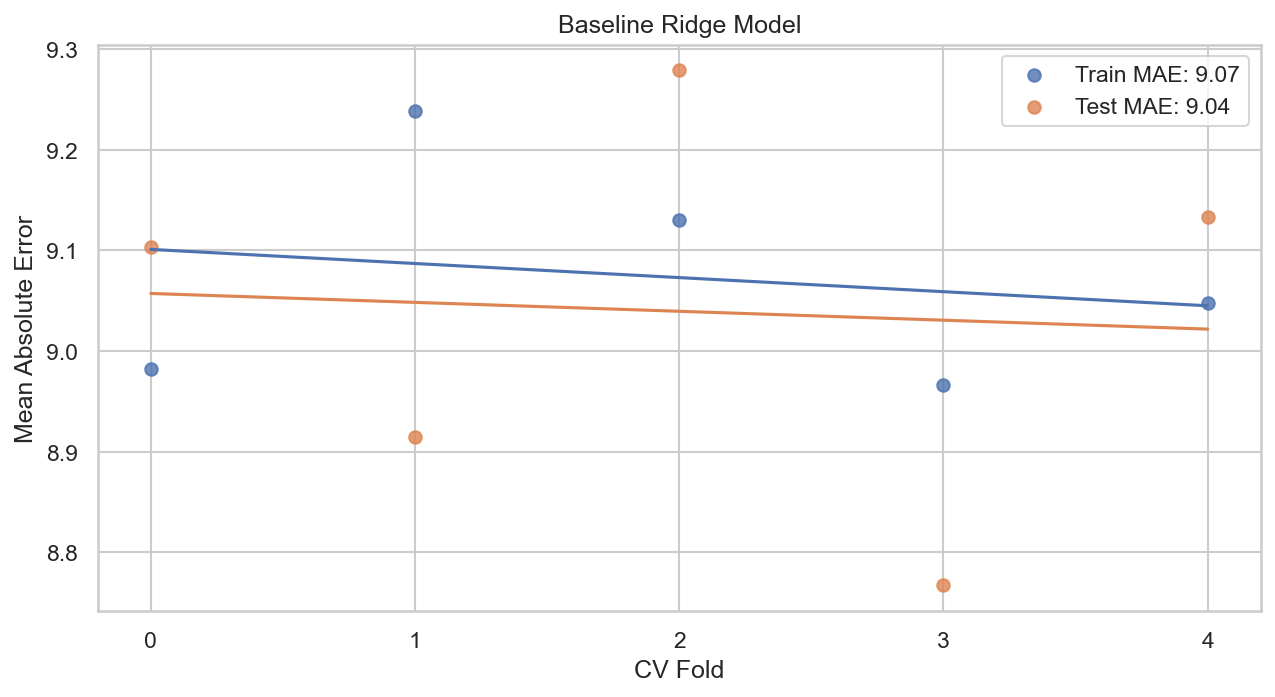

IMP FEATURES Index(['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male',
       'Internetservice_Dsl', 'Internetservice_Fiber_Optic', 'MonthlyCharge',
       'Multiple_Yes', 'Onlinebackup_Yes', 'Onlinesecurity_Yes',
       'Streamingmovies_Yes', 'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure'],
      dtype='object')


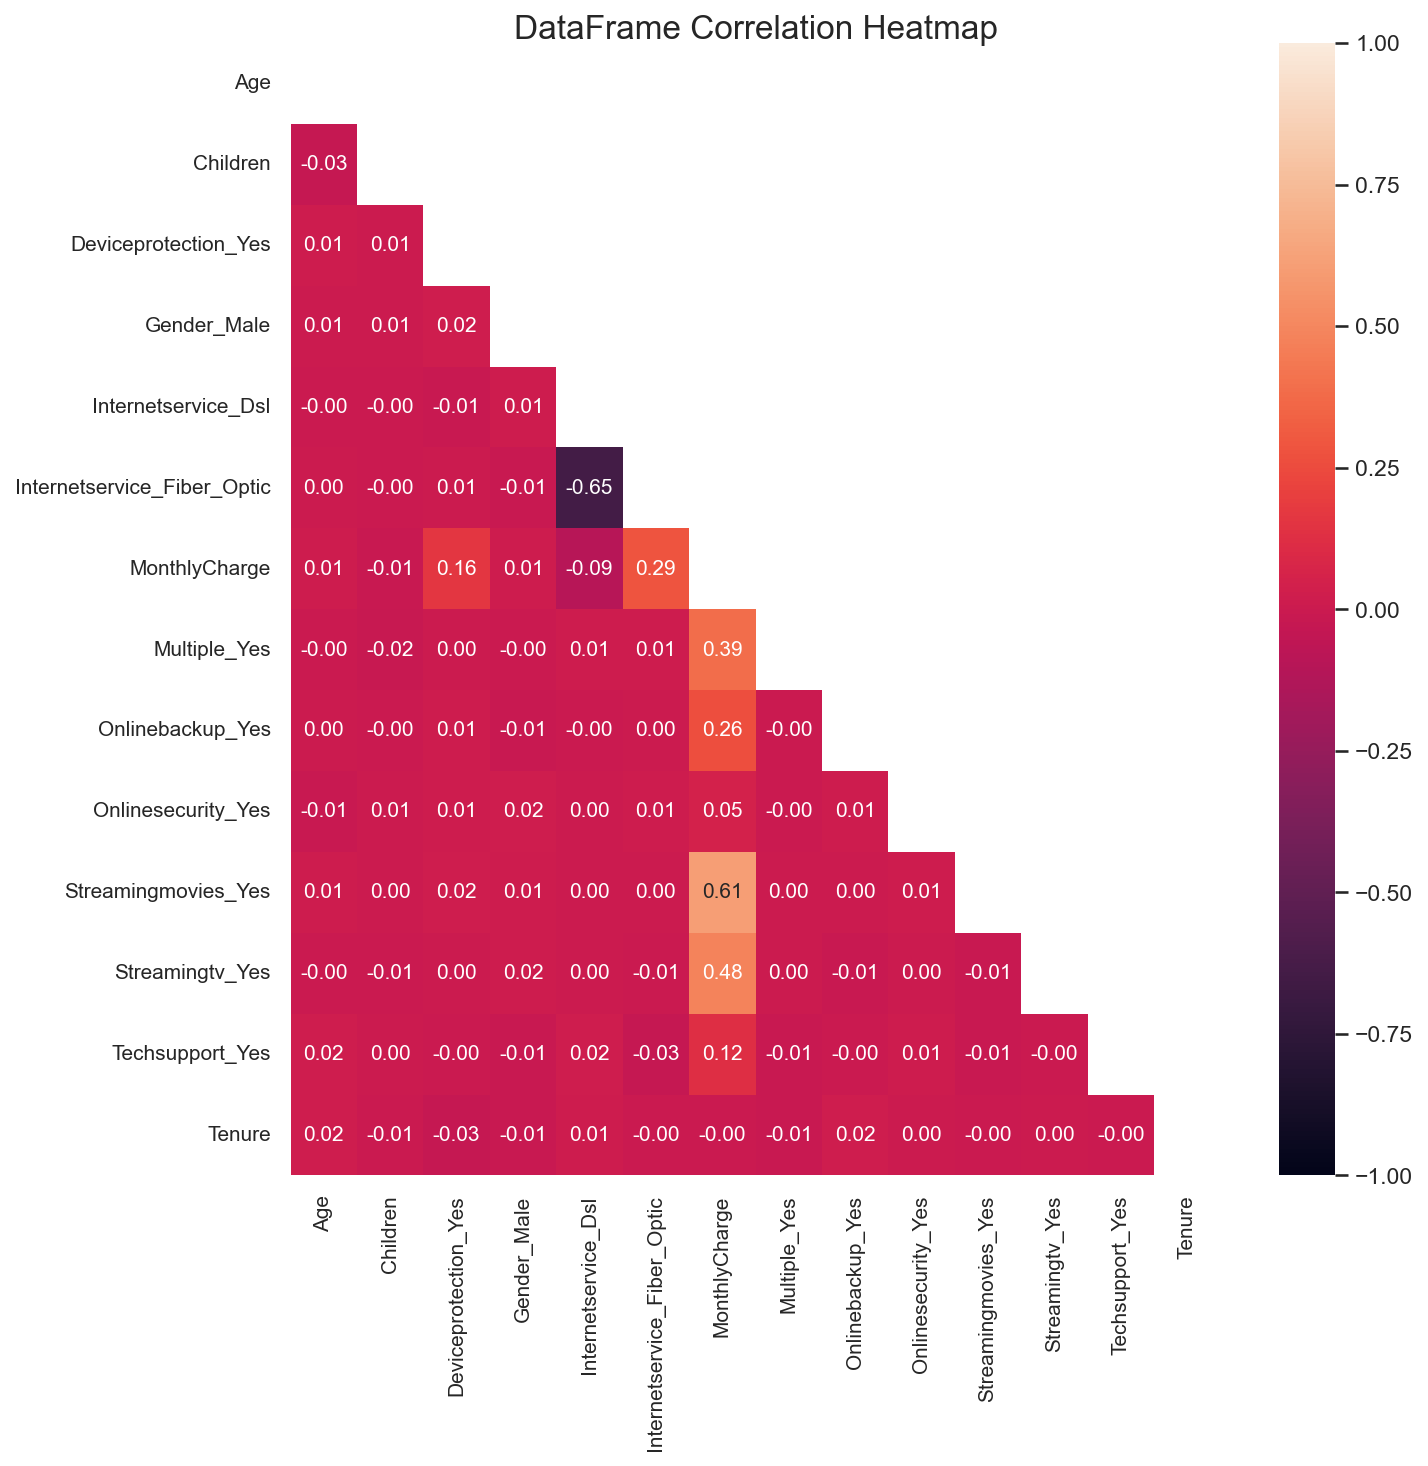

In [187]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV, ElasticNet

x_cols = ['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male',
       'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes',
       'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes',
       'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure']

# x_cols.remove("Internetservice_Dsl")
# x_cols.remove("Multiple_Yes")
# x_cols.remove("Streamingmovies_Yes")
# x_cols.remove("Streamingtv_Yes")
# x_cols.remove("Techsupport_Yes")
# x_cols.remove("MonthlyCharge")
# x_cols.remove("Internetservice_Fiber_Optic")
# x_cols.remove("Gender_Nonbinary")
# x_cols.remove("Gender_Male")
# x_cols.remove("Deviceprotection_Yes")
# x_cols.remove("Children")
# x_cols.remove("Age")


X_train, X_test, y_train, y_test = train_test_split(
    X[x_cols], y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("imp", SimpleImputer(missing_values=np.nan)),
    ("feature_selection", SelectFromModel(Lasso())),    
    ("elasticNet", ElasticNet(random_state=RANDOM_STATE))    
]

param_grid = {
    'elasticNet__alpha': np.arange(.05, .5, .05),
    'elasticNet__l1_ratio': np.arange(.5, 1, .05),    
}

elastic_net_pipeline = Pipeline(steps).fit(X_train, y_train)

cv = GridSearchCV(elastic_net_pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

print("BEST PARAMS", cv.best_params_)
print("BEST ESTIMATOR", cv.estimator.named_steps["elasticNet"])

important_feats = X_train.columns[cv.estimator["feature_selection"].get_support()]

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, cv, title="Baseline Ridge Model", xticks=[]
)

print("IMP FEATURES", important_feats)

lib.create_heatmap(df[important_feats], fontsize=10, figsize=(10, 10), title_fontsize=16)


#### Final ElasticNet Model
```
Train MAE: 9.07
Test MAE: 9.04
```

,# Variables,Train MAE,Test MAE,Best Model Params
0,14,9.07,9.04,"{'elasticNet__alpha': 0.05, 'elasticNet__l1_ratio': 0.95}"


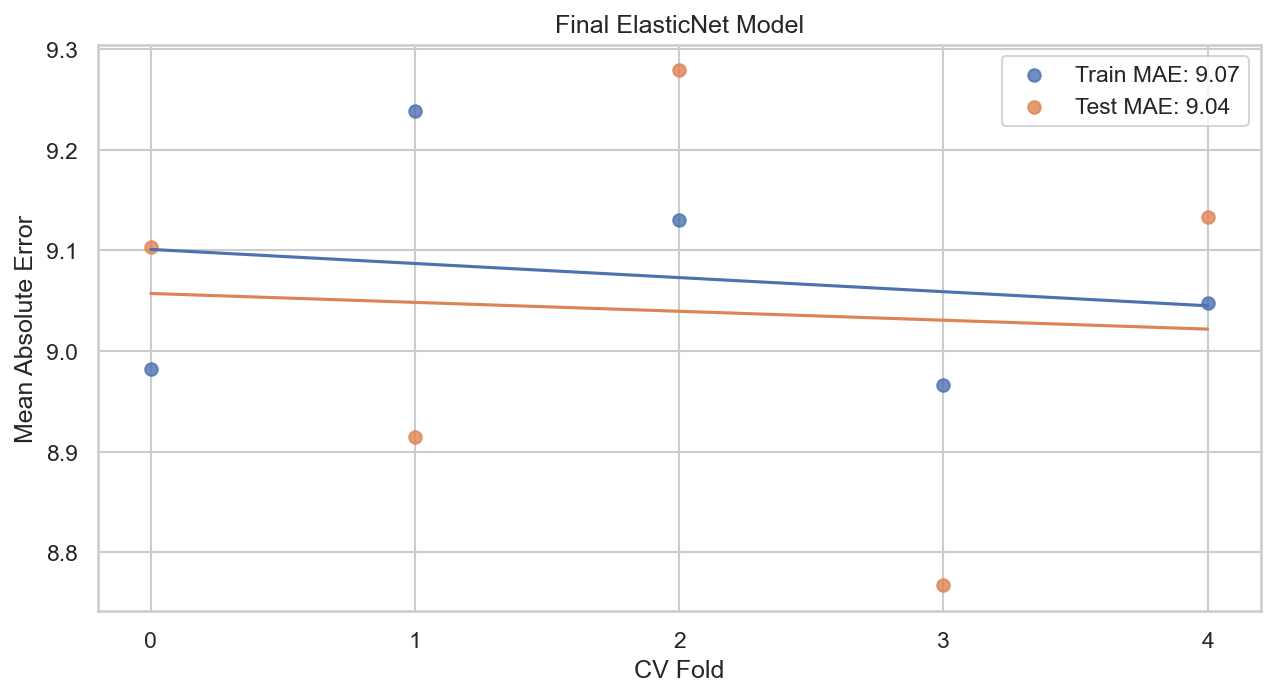

Best alpha using built-in ElasticNet: 4.326519732206713
Best R2 score using built-in ElasticNet: -230.83652516560988
Lasso selected ['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male', 'Internetservice_Dsl', 'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes', 'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes', 'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure']
Lasso selected 14 variables and eliminated 0 variables


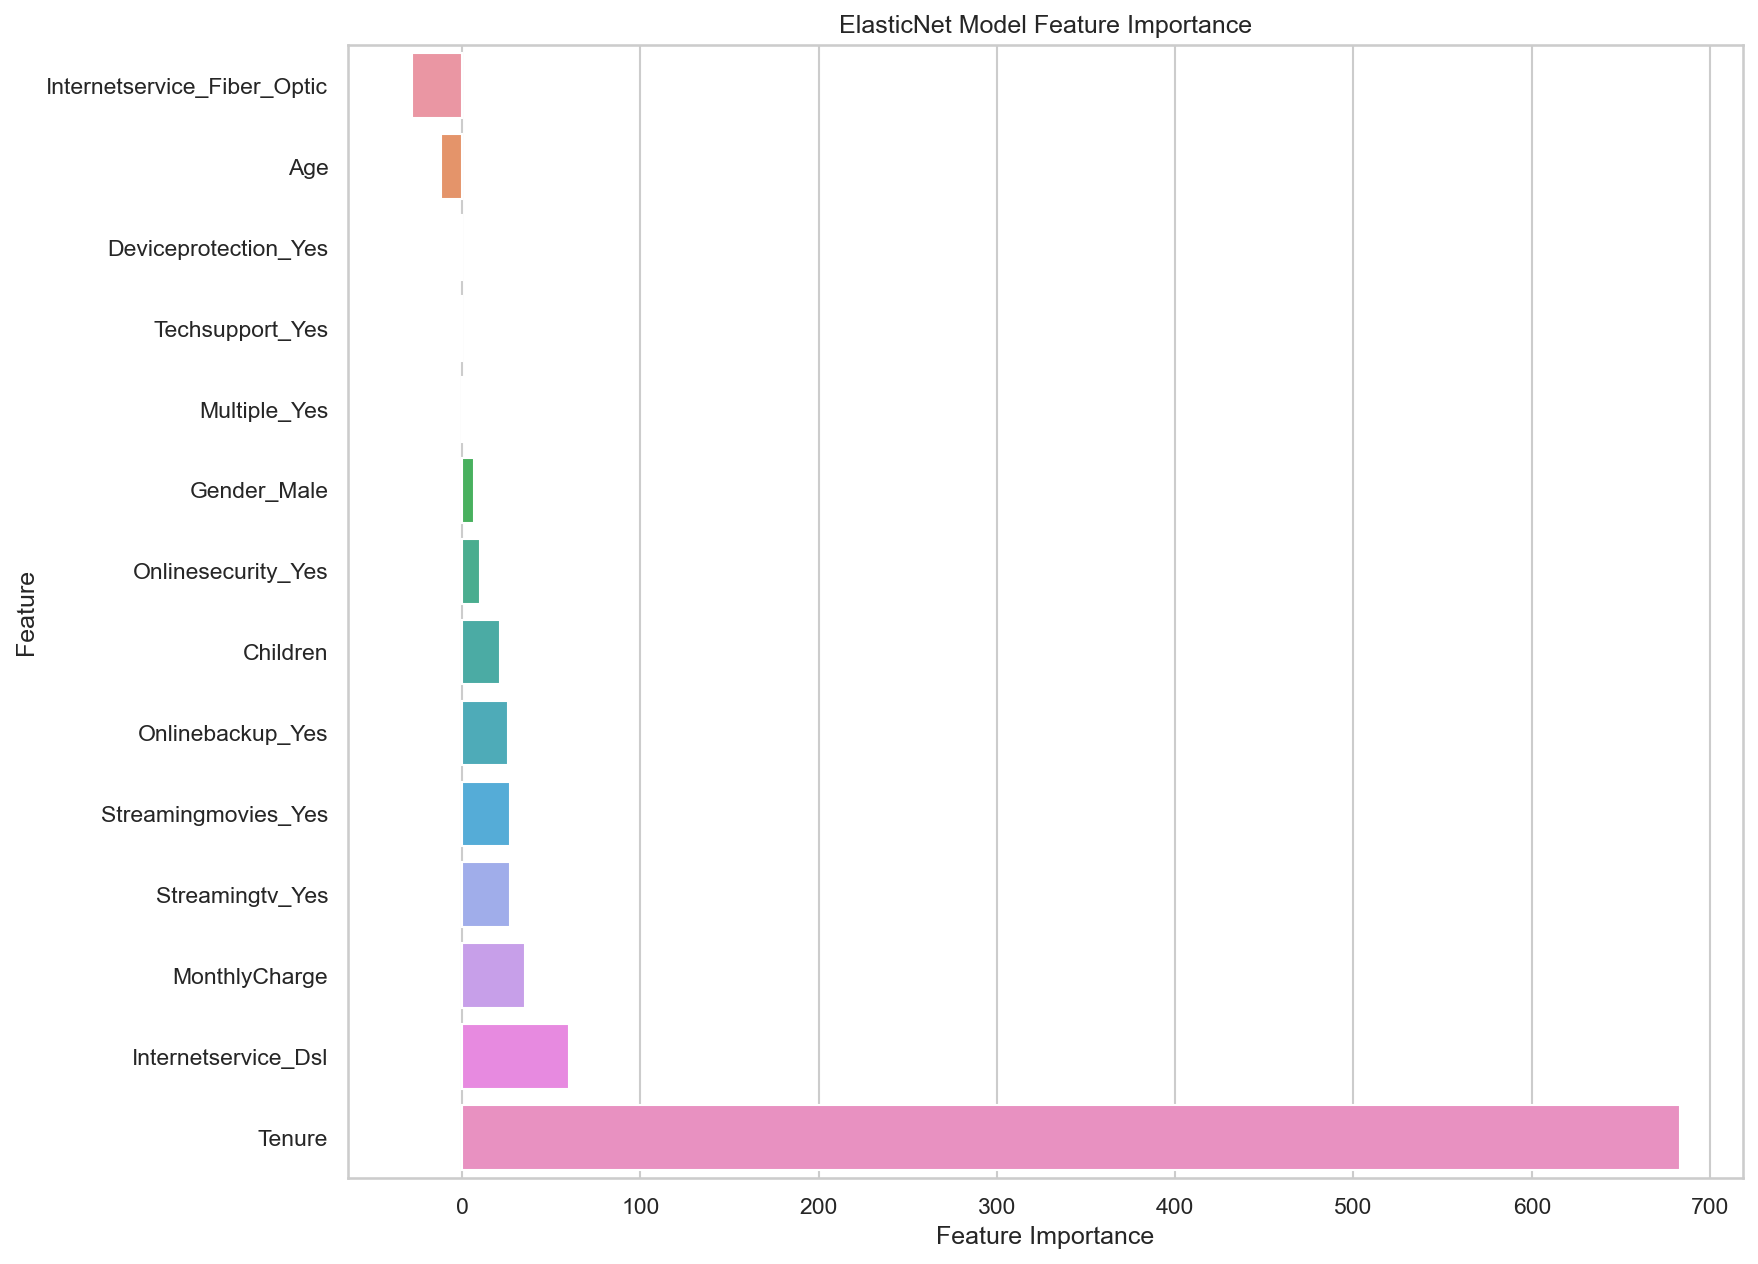

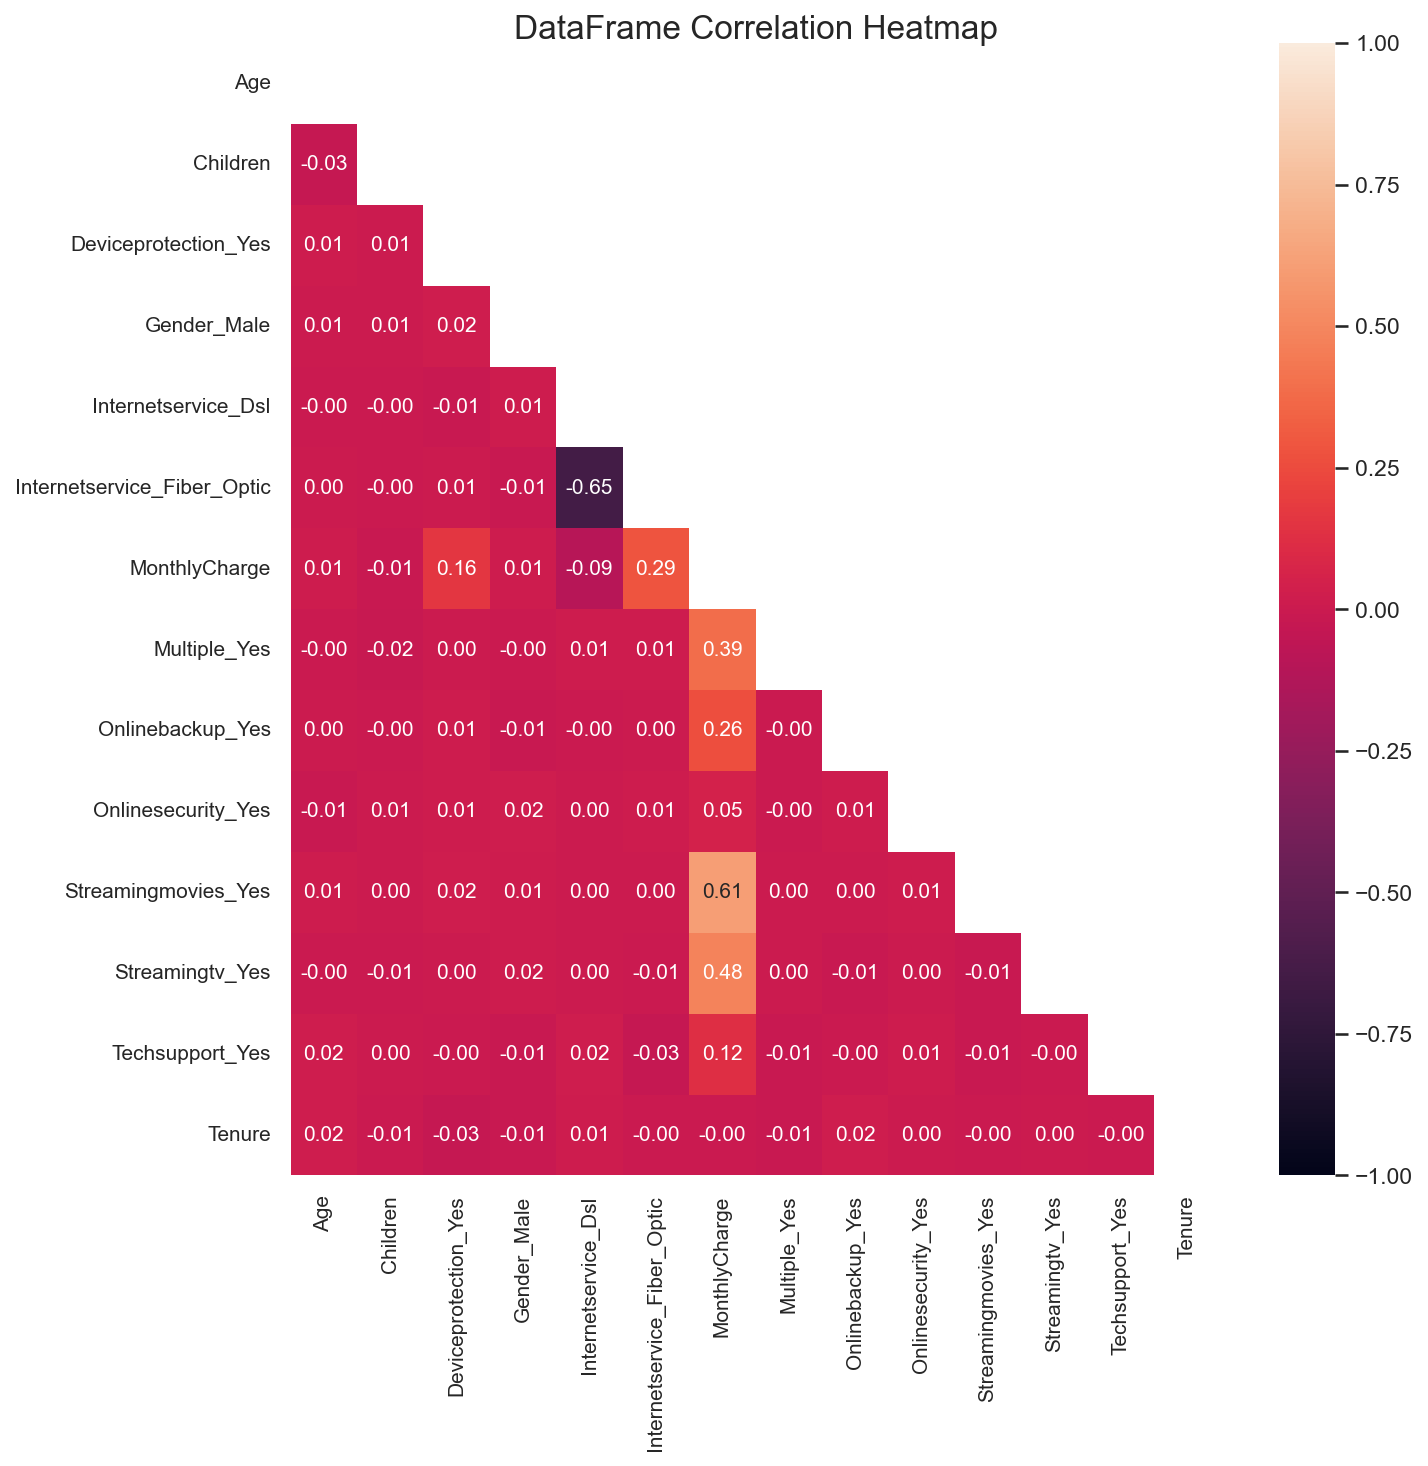

In [251]:
FINAL_X_COLS = ['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male','Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes',
       'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes',
       'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure']

X_train, X_test, y_train, y_test = train_test_split(
    X[FINAL_X_COLS], y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("imp", SimpleImputer(missing_values=np.nan)),  
    ("elasticNet", ElasticNet(random_state=RANDOM_STATE))    
]

param_grid = {
    'elasticNet__alpha': [0.05],
    'elasticNet__l1_ratio': [0.95]
}

elastic_net_pipeline = Pipeline(steps).fit(X_train, y_train)

FINAL_MODEL = GridSearchCV(elastic_net_pipeline, param_grid=param_grid, cv=5).fit(X_train, y_train)

lib.plot_error_lines(
    X_train, X_test, y_train, y_test, FINAL_MODEL, title="Final ElasticNet Model", xticks=[]
)

lib.plot_elastic_net_feature_importance(X_train, y_train)

lib.create_heatmap(df[FINAL_X_COLS], fontsize=10, figsize=(10, 10), title_fontsize=16)


Best alpha using built-in LassoCV: 2.1632598661033566
Best score using built-in LassoCV: -2408.9228507132557
selected cols Index(['Age', 'Children', 'Deviceprotection_Yes', 'Gender_Male',
       'Gender_Nonbinary', 'Internetservice_Dsl',
       'Internetservice_Fiber_Optic', 'MonthlyCharge', 'Multiple_Yes',
       'Onlinebackup_Yes', 'Onlinesecurity_Yes', 'Streamingmovies_Yes',
       'Streamingtv_Yes', 'Techsupport_Yes', 'Tenure'],
      dtype='object')
Lasso selected 15 variables and eliminated 37 variables


,Feature,Feature Importance,Feature Importance (SN)
0,Age,-65.77,-6.576976073633236e+01
1,Internetservice_Fiber_Optic,-43.18,-4.317630330803816e+01
2,Techsupport_Yes,-12.16,-1.2156363164638826e+01
3,Multiple_Yes,-6.30,-6.296908088859171e+00
4,Gender_Nonbinary,-1.32,-1.3162912193294263e+00
42,Onlinebackup_Yes,14.08,1.4080661051972879e+01
43,Deviceprotection_Yes,23.04,2.3039019868089692e+01
44,Gender_Male,30.68,3.067994459402922e+01
45,Onlinesecurity_Yes,30.74,3.0740069635645472e+01
46,Streamingmovies_Yes,31.70,3.170031766814358e+01


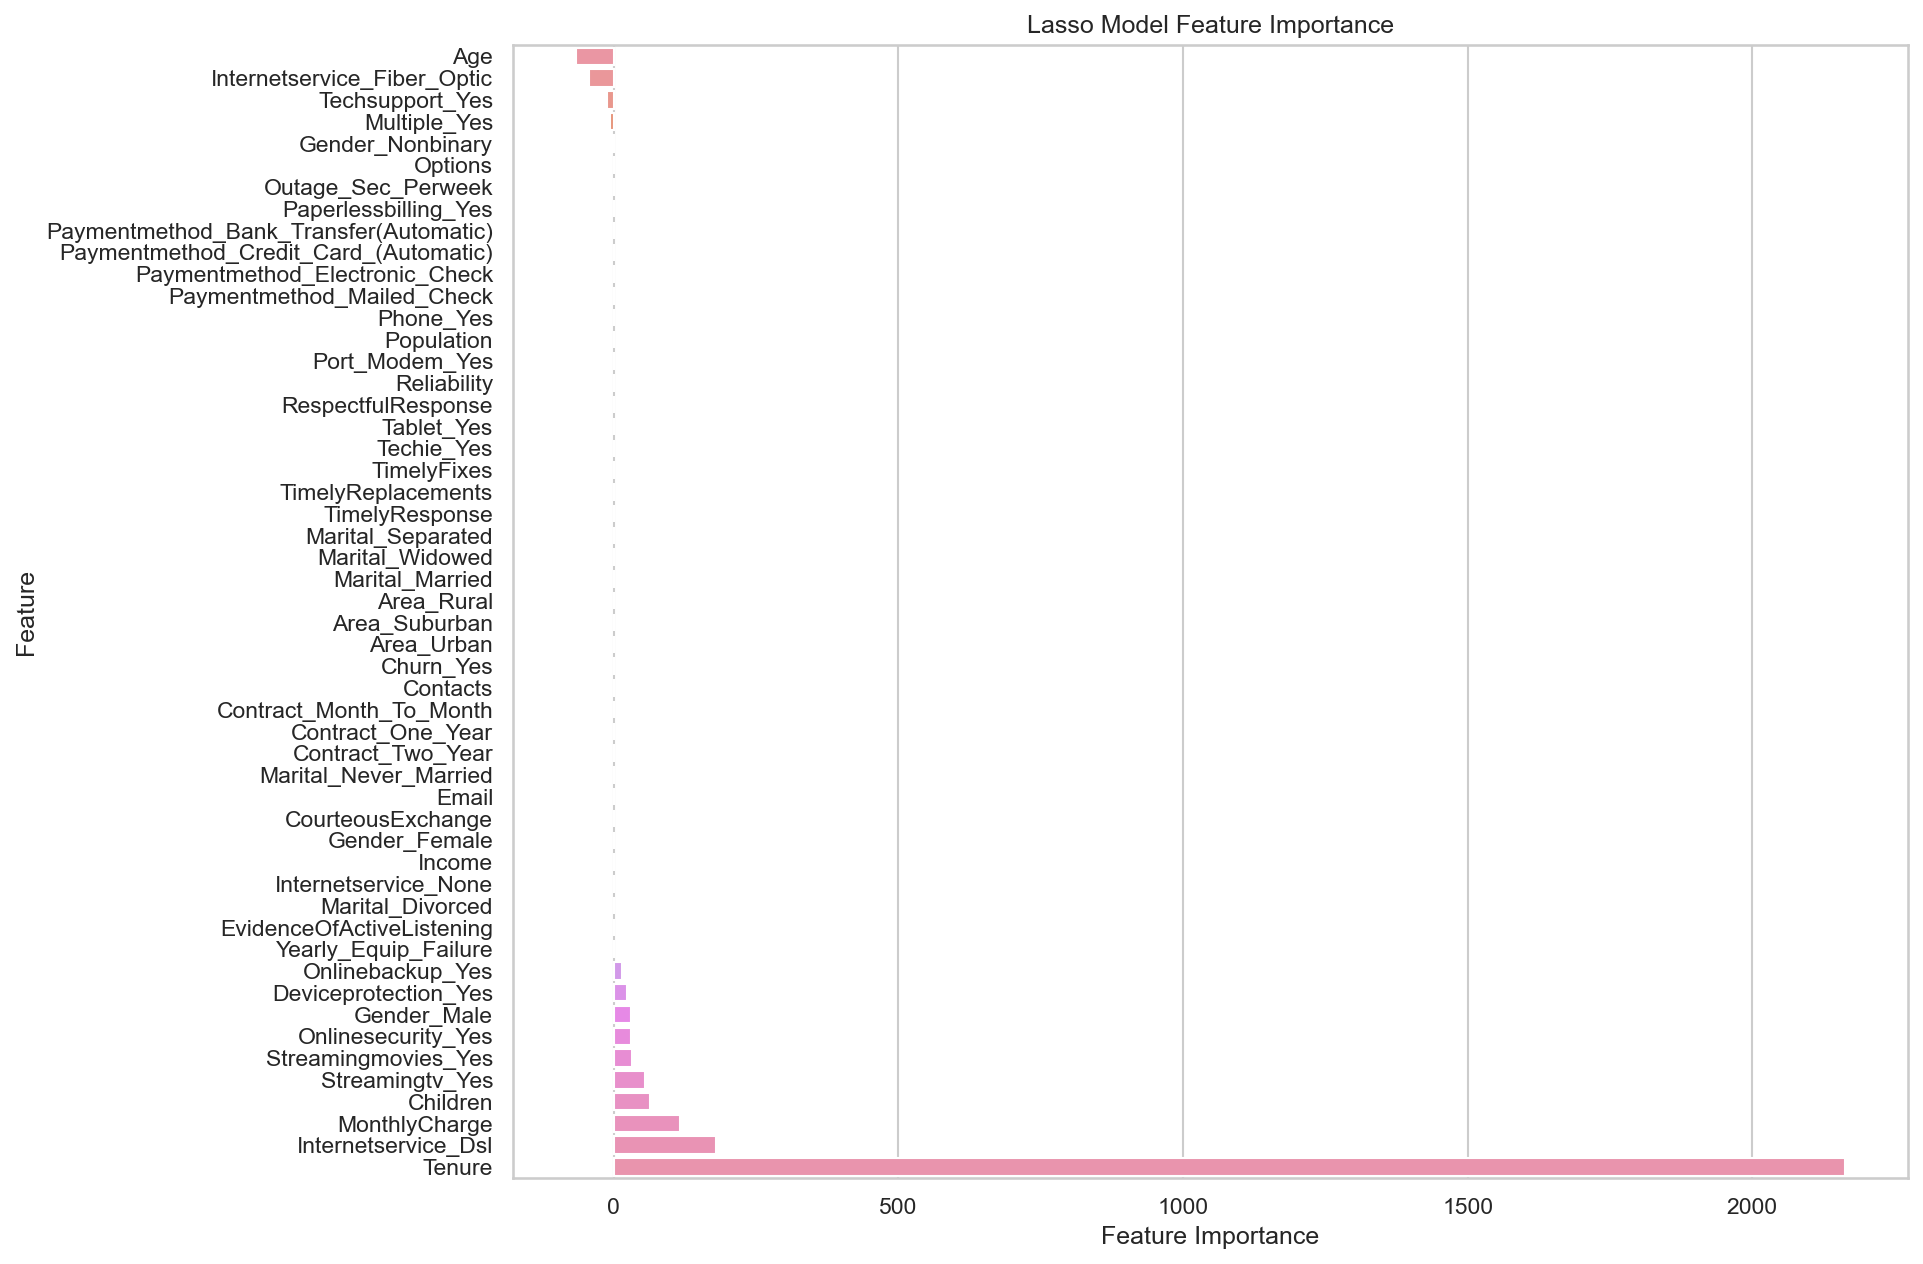

In [222]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

steps = [
    ("scaler", StandardScaler()),
    ("lasso", LassoCV()),
]

pipeline = Pipeline(steps).fit(X_train, y_train)

reg = pipeline.named_steps.get("lasso")

print("Best alpha using built-in LassoCV:", reg.alpha_)
# coefficient of determination of the prediction.
print("Best score using built-in LassoCV:", reg.score(X_train, y_train))
# The amount of penalization chosen by cross validation.
coef = pd.Series(reg.coef_, index=X_train.columns)

selected_vars = abs(coef) > 0
selected_cols = coef[selected_vars == True].index
# selected_vars =
print("selected cols", selected_cols)
num_selected_vars = sum(selected_vars)

print(
    f"Lasso selected {num_selected_vars} variables and eliminated { sum(abs(coef) == 0) } variables"
)

imp_coef = coef.sort_values()
imp_coef = pd.DataFrame(
    {
        "Feature Importance": imp_coef,
        "Feature Importance (SN)": imp_coef.apply(np.format_float_scientific),
    }
)
imp_coef.reset_index(inplace=True)
imp_coef = imp_coef.rename(columns={"index": "Feature"})

barplot = sns.barplot(data=imp_coef, y="Feature", x="Feature Importance", orient="h")
barplot.set_title("Lasso Model Feature Importance")

imp_coef[abs(imp_coef["Feature Importance"]) > 0]


##### Correlation: LinearSVC Pipeline + LASSO CV Feature Selection + Correlation Reduced Features

In [ ]:
# reduced based on LinearSVC in model pipeline -> reduced based on LASSO -> reduced based on correlation
x_cols = [
    "MonthlyCharge",
    "Contract_Month_To_Month",
    "Internetservice_Fiber_Optic",
    "Multiple_Yes",
    "Streamingtv_Yes",
    "Techie_Yes",
    "Tenure",
]

lib.create_heatmap(df[x_cols], fontsize=10, figsize=(10, 10), title_fontsize=16)

X_train, X_test, y_train, y_test = train_test_split(
    X[x_cols], y, test_size=0.2, random_state=RANDOM_STATE
)
_ = lib.plot_lasso_feature_importance(X_train, y_train)


# Part V: Data Summary and Implications
---

## E.  Summarize your data analysis by doing the following:


### 1.  Explain the accuracy and the mean squared error (MSE) of your prediction model.
*The submission explains both the accuracy and the MSE of the prediction model.*

> After hyperparameter tuning and reducing overfitting, the model's accuracy was similar on both train and test data. The training data saw a 91% accuracy, while the test data saw an 89% accuracy. This indicates that roughly 90% of the time the model correctly identified customers that churned as well as customers that didn't churn. We calculate accuracy by adding the True Positive (421) and True Negative (1361) values and then dividing by the total number of observations in the dataset (2000).

> Precision or Positive Predictive Value represents the model's ability to positively identify a customer that has churned or will churn when the model makes a positive prediction. More generally, this represents the number of true positives out of all predicted positive values. The model correctly predicted 421 true positives but also predicted 81 false positives. The final model had a precision of 83.9% which indicates that when it made a positive prediction, it was correct 83.9% of the time. Focusing on precision is critical when the model needs to avoid overpredicting positive values. 

> Recall or True Positive Rate represents the model's ability to positively identify a customer that has churned or will churn. The model correctly predicted 421 true positives but also predicted 137 false negatives. More generally, this represents how well the model predicted true positives out of all possible true positive values. Recall is important when a model needs to capture all true positive values. The final model had a recall of 75.5%, indicating it detected 75.5% of all possible true positive values.

> F1-Score represents the harmonic mean between precision and recall. This value provides a balanced metric used to compare. The final model had an F1-Score of 79.4%. This model's precision is higher than its recall — indicating that generally, it's stronger at correctly classifying a customer or has or well churn when it makes a true positive prediction.

#### Accuracy Metrics

In [ ]:
X = df.drop(TARGET_VAR, axis=1)
y = df[[TARGET_VAR]]
X_train, X_test, y_train, y_test = train_test_split(
    X[FINAL_X_COLS], y, test_size=0.2, random_state=RANDOM_STATE
)

y_pred = FINAL_MODEL.predict(X_test)

TN, FP, FN, TP = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
n, _ = y_test.shape

accuracy = lambda TP, TN, n: (TP + TN) / n * 100
precision = lambda TP, FP: TP / (TP + FP) * 100
recall = lambda TP, FN: TP / (TP + FN) * 100

# The weighted harmonic mean is the preferable method for averaging multiples such as ratios.
F1_score = lambda precision, recall: harmonic_mean([precision, recall])

print(f"Test Data Accuracy: {rnd(accuracy(TP,TN, n))}%")
print(f"Test Data Precision: {rnd(precision(TP,FP))}%")
print(f"Test Data Recall: {rnd(recall(TP,FN))}%")
print(f"Test Data F1-Score: {rnd(F1_score(precision(TP,FP), recall(TP,FN)))}%")


In [ ]:
print(classification_report(y_test, y_pred))


In [ ]:
lib.create_classification_metrics(y_test, y_pred)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X[FINAL_X_COLS], y, test_size=0.2, random_state=RANDOM_STATE
)

lib.plot_accuracy_lines(
    X_train, X_test, y_train, y_test, FINAL_MODEL, title="Base KNN Model", xticks=[]
)


#### MSE
> The Receiver operating characteristic (ROC) curve graph is a two-dimensional representation of our classifier's performance. The classifier's True Positive Rate is plotted on the Y-axis and the False Positive Rate is plotted on the X-axis. This depicts the model's "relative tradeoffs between benefits (true positives) and costs (false positives)" (Fawcett, 2005). To compare classifier performance, we can calculate the area under the ROC curve (AUC) and use a singular value to represent the curve. The AUC represents a "portion of the area of the unit square, its value will always be between 0 and 1.0" (Fawcett, 2005). The diagonal line represents randomly guessing if a customer will churn and being correct 50% of the time. Ultimately, the AUC value assesses how well a model can order observations from a low probability of being the target to a high probability of being the target. sklearn.metrics.roc_auc_score function can be used to calculate the AUC of the model. To visualize the ROC curve, we can use sklearn.metrics.RocCurveDisplay and supply the model. The graph indicates our model has a 0.94 AUC value which indicates it performs well at identifying customers that have churned as opposed to misclassifying customers that did not churn.

In [ ]:
lib.plot_ROC_curve(estimator=FINAL_MODEL, X_test=X_test, y_test=y_test)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X[FINAL_X_COLS], y, test_size=0.2, random_state=RANDOM_STATE
)

X = df[FINAL_X_COLS]
y = df[TARGET_VAR].values.ravel()

# Compute predicted probabilities: y_pred_prob
y_pred_prob = FINAL_MODEL.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# We will use three repeats of 10-fold cross-validation, meaning that 10-fold cross-validation is
# applied three times fitting and evaluating 30 models on the dataset.
# The dataset is stratified, meaning that each fold of the cross-validation split will have the same
# class distribution as the original dataset
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Compute cross-validated AUC scores: cv_auc
scores = cross_val_score(FINAL_MODEL, X, y, cv=rskf, scoring="roc_auc", n_jobs=-1)

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(scores))
print(
    "Mean AUC score computed using 5-fold cross-validation: {}".format(np.mean(scores))
)


### 2.  Discuss the results and implications of your prediction analysis.
*The submission adequately discusses both the results and implications of the prediction analysis.*

> We successfully used existing customer data to predict if a customer will churn with 90% accuracy using the k-nearest neighbor classification method. According to the model, customer tenure played a significant role in reducing churn, followed by providing fiber optic service to a customer. Inversely, monthly charges and customers with month-to-month contracts significantly impacted a customer's decision to churn.

> A KNN model using all 52 data features without standardization performed poorly and overfit to the training data. This model saw 71% accuracy, an F1 Score of 0.4 and a ROC Score of 0.61 on test data.

> After standardization, feature selection, and hyperparameter tuning, our cross-validated model saw 89% accuracy, an F1 Score of 0.8 and a ROC Score of 0.85 on test data. This model eliminated overfitting and performed equally well on the larger training dataset. Overall, the model pipeline removed more than 40 data features and determined that Monthly Charges, Month-to-Month Contracts, Fiber Internet, Streaming, a customer's Tech Savviness and Tenure were key features in determining churn.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X[FINAL_X_COLS], y, test_size=0.2, random_state=RANDOM_STATE
)
_ = lib.plot_lasso_feature_importance(X_train, y_train)


### 3.  Discuss one limitation of your data analysis.

*The submission logically discusses 1 limitation of the data analysis with adequate detail.*

>Even though we've developed a classification model that can pretty accurately classify customer churn, the analysis isn't without limitations. Our feature selection primarily automated by classification estimators, as opposed to a deep understanding of the data features. This approach was beneficial in reducing the number of explanatory variables, but this also indicates that different researchers, using the same data and attempting to classify customer churn may select different data features and ultimately arrive at a different conclusion.

> Additionally, this model doesn't indicate when the customer will churn or suggest a course of action to prevent churn. Furthermore, there isn't a clear audit trail that provides a date when the customer churned — perhaps there's significant seasonality to churn. Lastly, the dataset doesn't indicate why a customer churned.

### 4.  Recommend a course of action for the real-world organizational situation from part A1 based on your results and implications discussed in part E2.
*The submission recommends a reasonable course of action for the real-world organizational situation from part A1 based on the results and implications discussed in part E2.*

> My recommended course of action based on the final model's results is to use the model, to run a weekly analysis report to monitor customers that are likely at risk of churning. Over the next few years, I would continue to evaluate how well the model accurately predicts customers that may churn and see what business impacts the model has had.

> I also suggest capturing additional churn metadata such as a customer's churn reason and the data that they've churned. This information will allow the company to better understand when and why a customer churns.

> Long term, I recommend focusing fewer company resources on customers that are less likely to churn. Additionally, stakeholders should consider re-evaluating monthly charges for customers that have Month-to-Month contracts — if a customer's monthly charge is higher than average, consider offering the customer a lower rate if they sign up for an annual contract.

# Part VI: Demonstration
---

## F.  Provide a Panopto video recording that includes a demonstration of the functionality of the code used for the analysis and a summary of the programming environment.
*The submission provides a Panopto video recording that includes a demonstration of the functionality of the code used for the analysis and a summary of the programming environment.*

## G.  Web Sources

- https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
- https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_estimator
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
- https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification
- https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver
- https://stackoverflow.com/questions/28822756/getting-model-attributes-from-pipeline
- https://stackoverflow.com/questions/53313585/how-do-i-increase-the-padding-on-my-pandas-dataframe-plot
- https://www.geeksforgeeks.org/python-statistics-harmonic_mean/
- https://www.statology.org/pandas-merge-on-index/

-- 

- https://github.com/scikit-learn/scikit-learn/issues/22093
- https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython


## H. References

- https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/

---

AskPython. (2020, October 13). 2 Easy Ways to Standardize Data in Python for Machine Learning. AskPython. Retrieved June 19, 2022, from https://www.askpython.com/python/examples/standardize-data-in-python 

Bowne-Anderson, H. (2016, April 25). Preprocessing in Data Science (Part 1): Centering, Scaling, and KNN. DataCamp. Retrieved June 19, 2022, from https://www.datacamp.com/tutorial/preprocessing-in-data-science-part-1-centering-scaling-and-knn 

Fawcett, T. (2005, December 19). An introduction to ROC analysis. Pattern Recognition Letters. Retrieved June 19, 2022, from https://www.sciencedirect.com/science/article/abs/pii/S016786550500303X 

Great Learning Team. (2022, March 22). A Complete understanding of LASSO Regression. GreatLearning Blog: Free Resources what Matters to shape your Career! Retrieved Retrieved June 19, 2022, from https://www.mygreatlearning.com/blog/understanding-of-lasso-regression/ 

Harrison, O. (2019, July 14). Machine learning basics with the K-nearest neighbors algorithm. Medium. Retrieved June 19, 2022, from https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761 

Ingargiola, A., & contributors. (2015). What is the Jupyter Notebook. 1. What is the Jupyter Notebook? - Jupyter/IPython Notebook Quick Start Guide 0.1 documentation. Retrieved June 19, 2022, from https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html 

Joby, A. (2021, July 19). What Is K-Nearest Neighbor? An ML Algorithm to Classify Data. Learn Hub. Retrieved June 19, 2022, from https://learn.g2.com/k-nearest-neighbor 

Pandas. Pandas Documentation - pandas 1.4.1 documentation. (2022). Retrieved June 19, 2022, from https://pandas.pydata.org/docs/index.html 

scikit-learn developers. (2021). Getting started. Getting Started — scikit-learn 1.0.2 documentation. Retrieved June 19, 2022, from https://scikit-learn.org/stable/getting_started.html  

Wikipedia. (2022, June 4). K-nearest neighbors algorithm. Wikipedia. Retrieved June 19, 2022, from https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm 

__
